In [ ]:
!nvidia-smi

Sat Jun 18 17:03:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 引入函式庫
*斜體文字*

In [ ]:
import numpy as np
import scipy.io
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img,img_to_array
import matplotlib.pyplot as plt

#展現成果用
def display_mask(pred):
    mask = np.argmax(pred,axis=-1)
    plt.imshow(mask)

# mat = scipy.io.loadmat('dataset/annotations/0001.mat')

In [ ]:
def get_mask(pred):
    return np.expand_dims(np.argmax(pred,axis=-1), axis=-1)


# 連接google Drive

## 解壓縮資料集

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Machine_Learning/dataset.zip", 'r')
zip_ref.extractall("/tmp") #存在tmp
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 語意切割

In [ ]:
import os
input_path = '/tmp/dataset/photos' #圖片feature
target_path = '/tmp/dataset/annotations' #切割的label

IMAGE_SIZE = (220,148) #統一圖片大小

#讀出所有檔案的路徑
input_image_paths = sorted([os.path.join(input_path, fileName) for fileName in os.listdir(input_path) if fileName.endswith('.jpg')])

target_label_paths = sorted([os.path.join(target_path, fileName) for fileName in os.listdir(target_path) if fileName.endswith('.mat')])

## 把所有圖片讀出來

In [ ]:
def path_to_input_image(path):  #把一個path的圖片讀出為np array
    return img_to_array(load_img(path,target_size=IMAGE_SIZE)).astype('uint8')

image_list = []
for path in input_image_paths:
    image_list.append(path_to_input_image(path))
image_list = np.stack(image_list)
image_list = image_list/255.0
image_list.shape

(1004, 220, 148, 3)

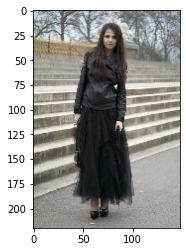

In [ ]:
plt.imshow(image_list[1]) #測試看看

## 把所有label 讀出來


In [ ]:
label_list = []

for i in range(len(target_label_paths)):
    currentFile = scipy.io.loadmat(target_label_paths[i])
    labelImage = currentFile['groundtruth']
    labelImage = cv2.resize(labelImage, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    labelImage.dtype = 'uint8'
    label_list.append(labelImage)
label_list = np.stack(label_list)
label_list = np.expand_dims(label_list, axis=-1)
label_list.shape  

(1004, 220, 148, 1)

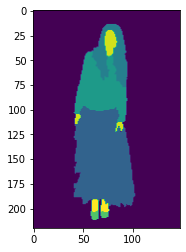

In [ ]:
plt.imshow(label_list[1,:,:,0]) #測試看看

## 分成training set和testing set

In [ ]:
#分成training set和testing set

np.random.seed(9999)
idx = np.random.permutation(1000)+1
training_idx = idx[:700]
validation_idx  = idx[700:750]
testing_idx  = idx[750:]

In [ ]:
training_image = image_list[training_idx]
training_label = label_list[training_idx]

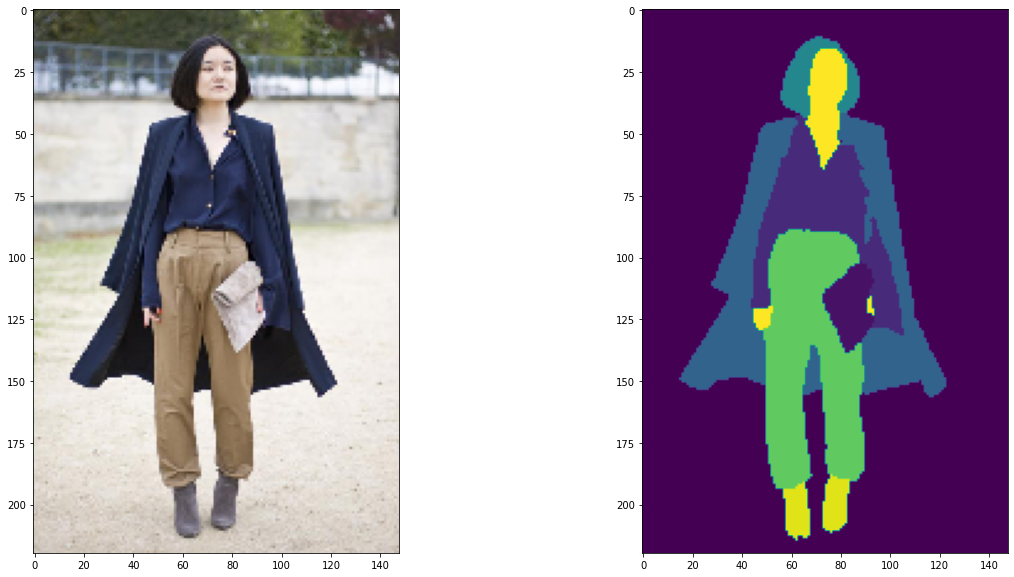

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(training_image[100])
plt.subplot(1,2,2)
plt.imshow(training_label[100,:,:,0])


In [ ]:
training_label[0,100]

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [41],
       [41],
       [41],
       [41],
       [41],
       [41],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],

In [ ]:
np.max(training_label)

58

In [ ]:
training_label.shape

(700, 220, 148, 1)

In [ ]:
training_image.shape

(700, 220, 148, 3)

## 切出validation set


In [ ]:
validation_image = image_list[validation_idx]
validation_label = label_list[validation_idx]
print(validation_image.shape)
print(validation_label.shape)

(50, 220, 148, 3)
(50, 220, 148, 1)


## 切出 test set

In [ ]:
test_image = image_list[testing_idx]
test_label = label_list[testing_idx]
print(test_image.shape)
print(test_image.shape)

(250, 220, 148, 3)
(250, 220, 148, 3)


## 建立網路

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE+(3,))
x = layers.Conv2D(128, 3, strides=2,activation='relu',padding='same')(inputs)
x = layers.Conv2D(128, 3,activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(256, 3, strides=2, activation='relu',padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(512, 3,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2DTranspose(512, 3, activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2DTranspose(256, 3,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(256, 1,strides=2,activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2DTranspose(128, 3,activation='relu',padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2DTranspose(128, 1,strides=2,activation='relu',padding='same')(x)
outputs = layers.Conv2D(59,3,activation='softmax',padding='same')(x)

model = keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 148, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 110, 74, 128)      3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 74, 128)      147584    
                                                                 
 dropout (Dropout)           (None, 110, 74, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 37, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 37, 256)       590080    
                                                                 
 dropout_1 (Dropout)         (None, 55, 37, 256)       0     

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from IPython.display import display
def show_model(model,figsize=(20,20)):
    a = plot_model(model, show_shapes=True, dpi=300)
    display(a)
    return

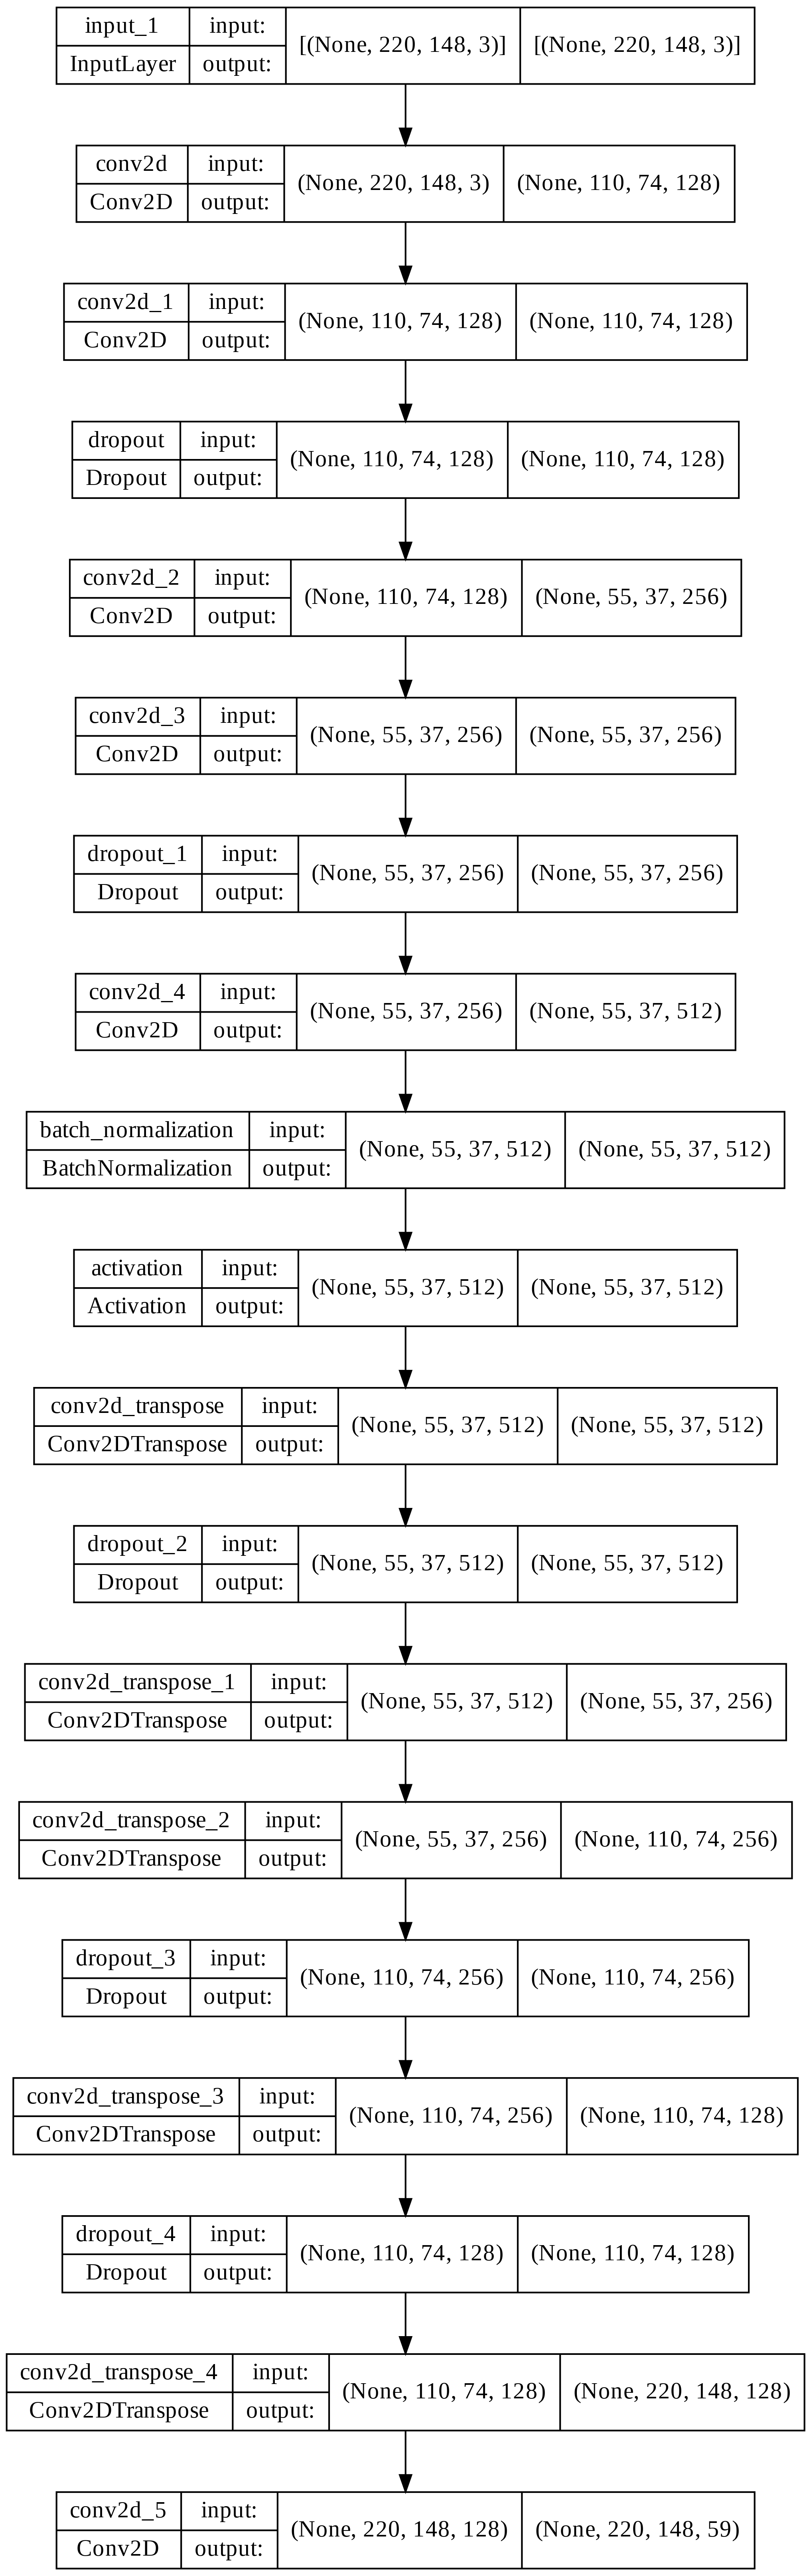

In [ ]:
show_model(model)

In [ ]:
model.predict(training_image[np.newaxis,0]).shape

(1, 220, 148, 59)

In [ ]:
np.sum(model.predict(training_image[np.newaxis,0])[0,10,1,:])

0.99999994

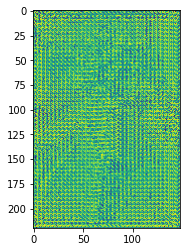

In [ ]:
display_mask(model.predict(training_image[np.newaxis,0])[0])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("mySegmentationNetwork.keras",save_best_only=True,monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)]

In [ ]:
history = model.fit(training_image,training_label,
                    callbacks=callbacks,
                    epochs=300,
                    batch_size=64,
                    validation_data=(validation_image,validation_label))

Epoch 1/300
11/11 [==============================] - 53s 3s/step - loss: 2.3365 - accuracy: 0.5719 - val_loss: 2.9408 - val_accuracy: 0.7775
Epoch 2/300
11/11 [==============================] - 13s 1s/step - loss: 1.1817 - accuracy: 0.7680 - val_loss: 3.3712 - val_accuracy: 0.7775
Epoch 3/300
11/11 [==============================] - 14s 1s/step - loss: 1.0887 - accuracy: 0.7685 - val_loss: 2.8168 - val_accuracy: 0.7775
Epoch 4/300
11/11 [==============================] - 14s 1s/step - loss: 1.0453 - accuracy: 0.7686 - val_loss: 2.7244 - val_accuracy: 0.7775
Epoch 5/300
11/11 [==============================] - 14s 1s/step - loss: 1.0193 - accuracy: 0.7686 - val_loss: 2.5464 - val_accuracy: 0.7775
Epoch 6/300
11/11 [==============================] - 14s 1s/step - loss: 1.0046 - accuracy: 0.7686 - val_loss: 2.2346 - val_accuracy: 0.7775
Epoch 7/300
11/11 [==============================] - 14s 1s/step - loss: 0.9955 - accuracy: 0.7686 - val_loss: 2.0103 - val_accuracy: 0.7775
Epoch 8/300
1

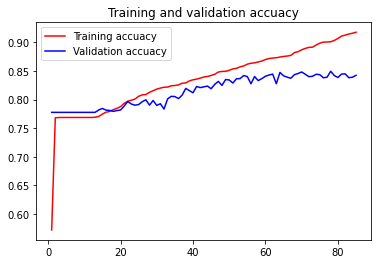

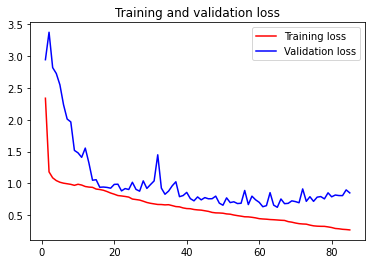

In [ ]:
accuacy = history.history['accuracy']
val_accuacy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuacy) + 1)
plt.plot(epochs, accuacy, 'r', label='Training accuacy')
plt.plot(epochs, val_accuacy, 'b', label='Validation accuacy')
plt.title('Training and validation accuacy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model('mySegmentationNetwork.keras')
test_loss, test_accuracy = test_model.evaluate(test_image,test_label)
print(f"test accuracy: {test_accuracy:.3f}")

8/8 [==============================] - 9s 693ms/step - loss: 0.6262 - accuracy: 0.8385
test accuracy: 0.838


In [ ]:
test_model_predicted = test_model.predict(test_image)
test_model_predicted.shape

(250, 220, 148, 59)

In [ ]:
test_model_predicted_mask = []
for predicted in test_model_predicted:
  test_model_predicted_mask.append(get_mask(predicted))
test_model_predicted_mask = np.stack(test_model_predicted_mask)
test_model_predicted_mask.shape

(250, 220, 148, 1)

In [ ]:
test_label.shape

(250, 220, 148, 1)

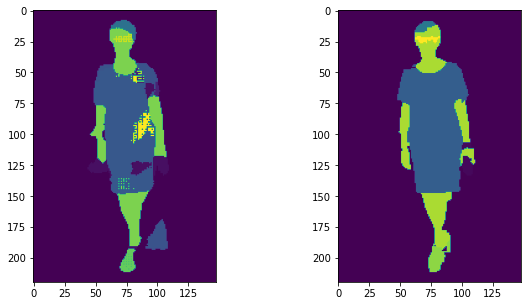

iou: 0.26086393


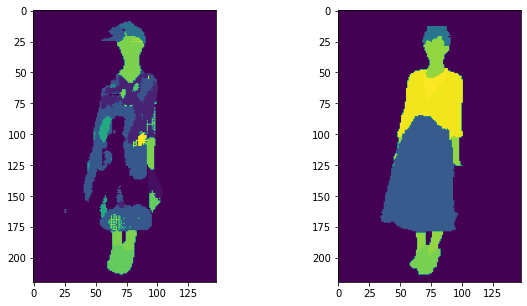

iou: 0.19277465


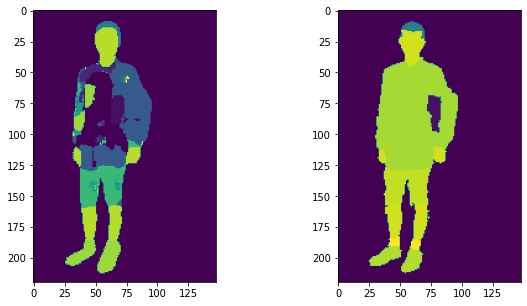

iou: 0.1632459


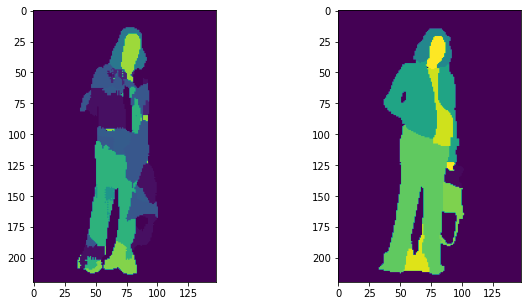

iou: 0.1858938


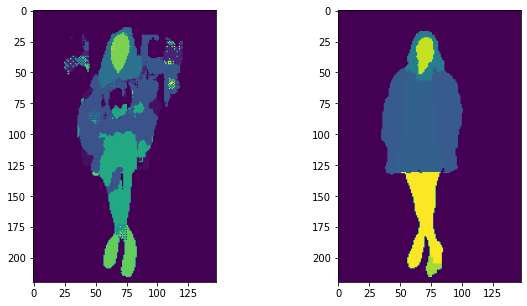

iou: 0.14640424


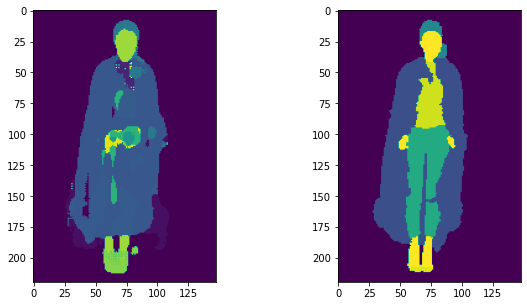

iou: 0.12430067


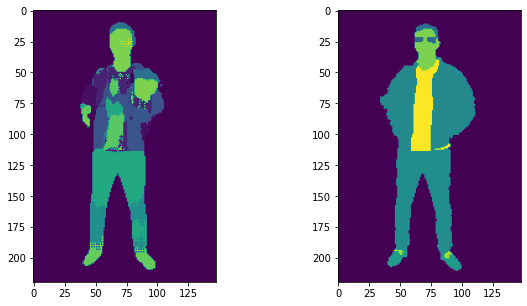

iou: 0.103546344


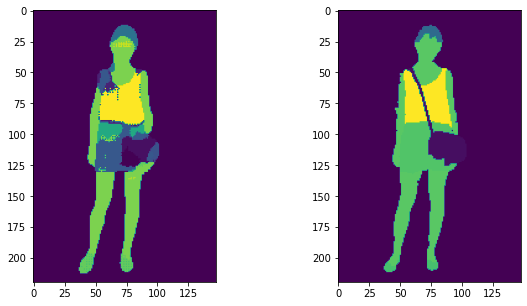

iou: 0.180822


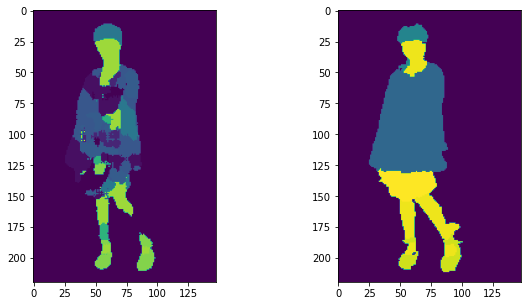

iou: 0.17170058


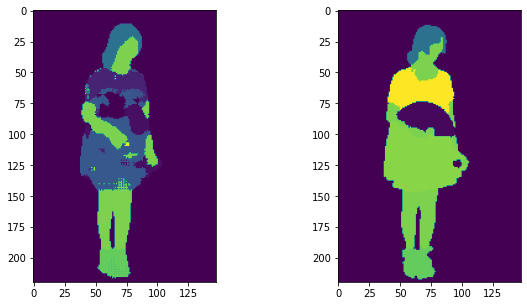

iou: 0.22053584


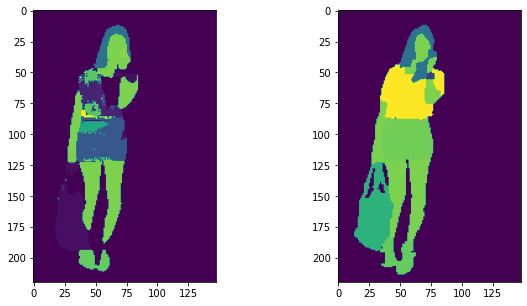

iou: 0.1503813


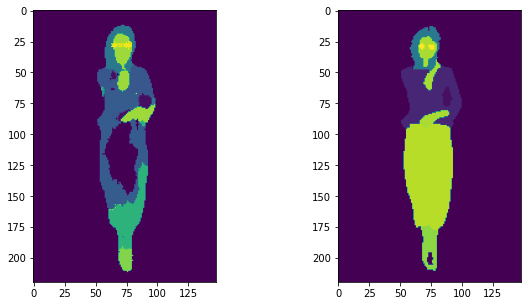

iou: 0.21242002


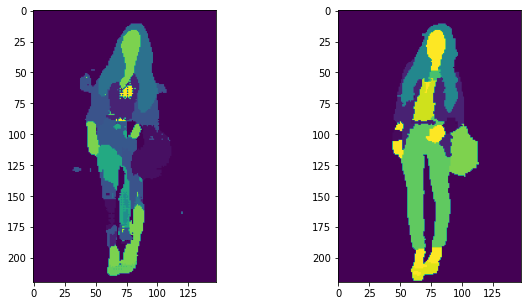

iou: 0.14522976


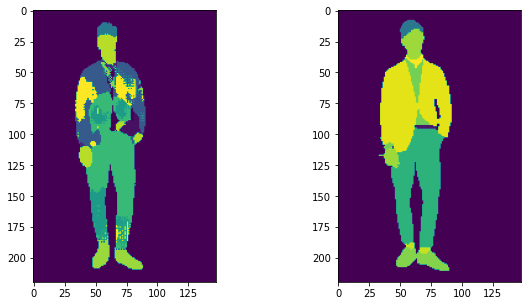

iou: 0.18420717


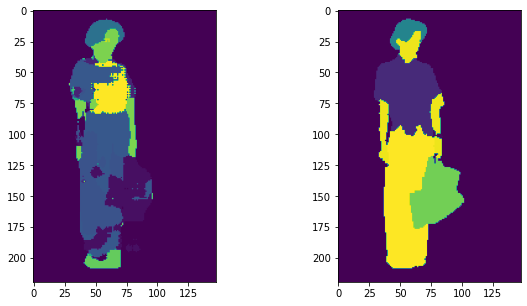

iou: 0.13697469


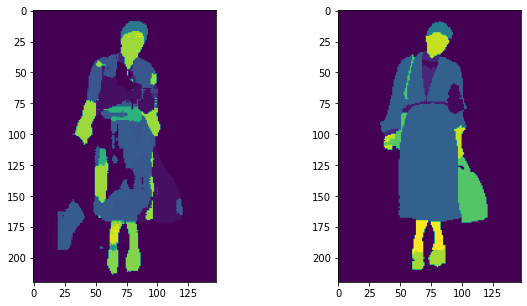

iou: 0.14347884


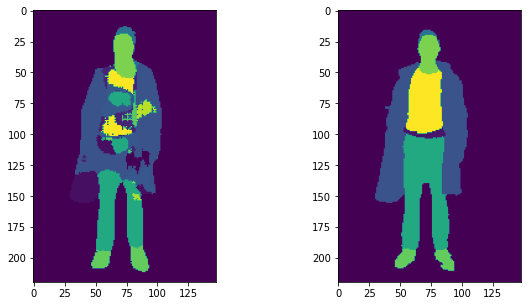

iou: 0.23484506


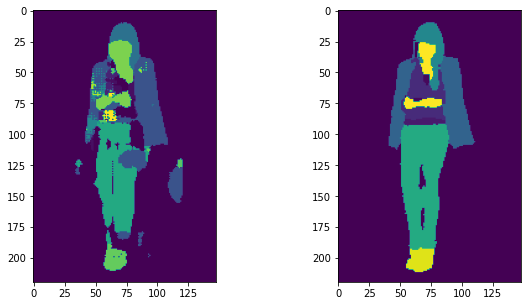

iou: 0.18328436


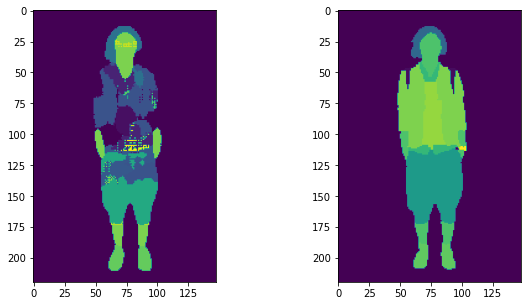

iou: 0.1560427


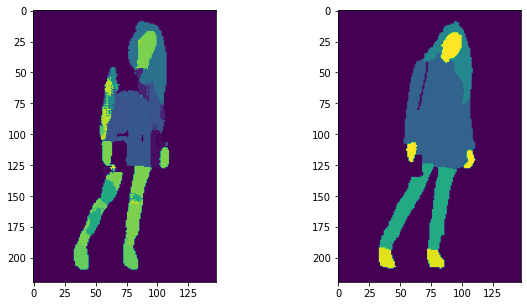

iou: 0.15940589


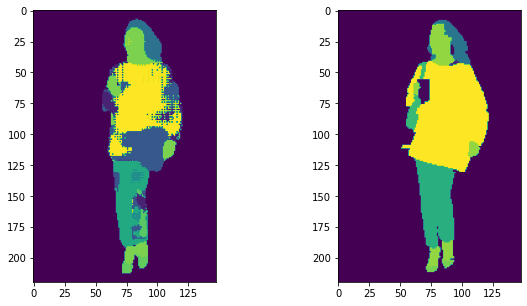

iou: 0.14993335


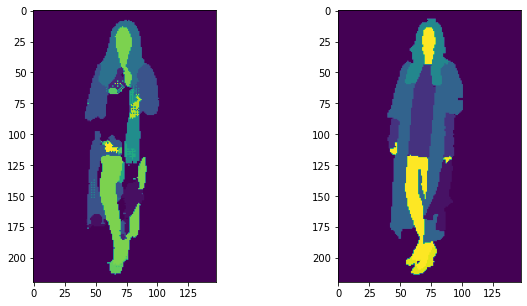

iou: 0.20490707


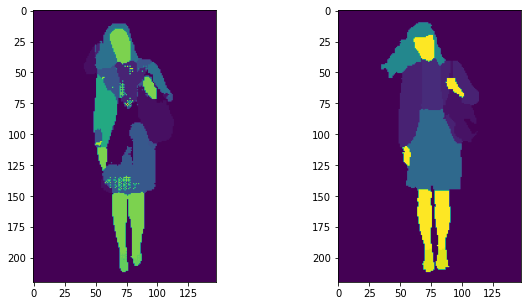

iou: 0.25671196


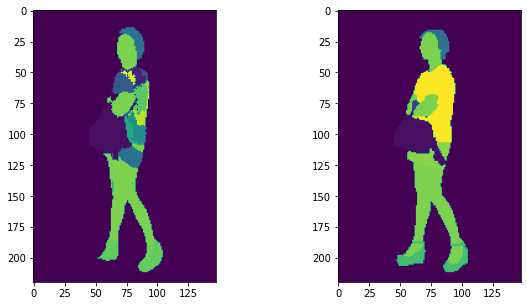

iou: 0.16673821


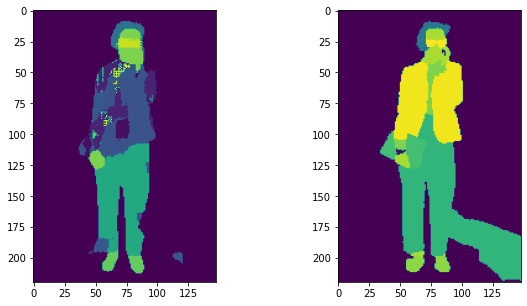

iou: 0.23374517


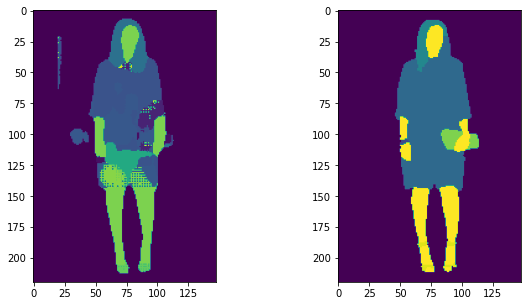

iou: 0.124829486


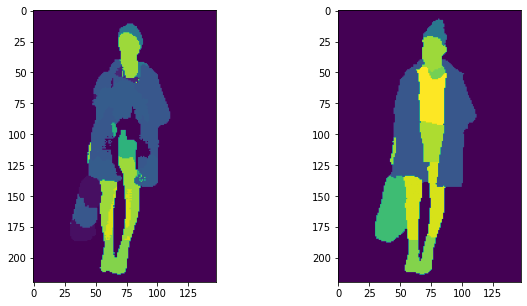

iou: 0.22791038


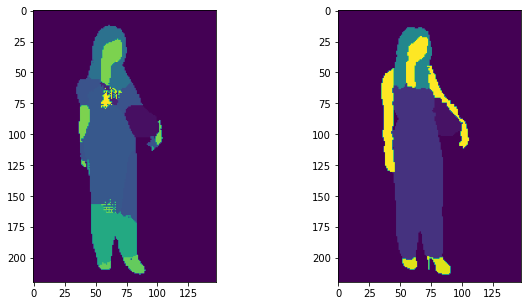

iou: 0.21370588


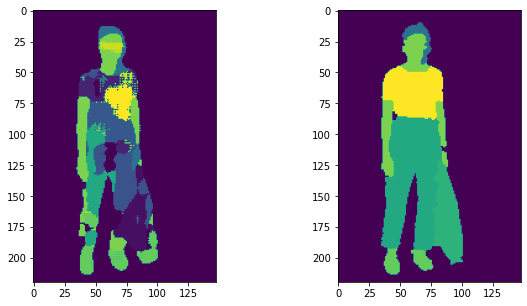

iou: 0.14226545


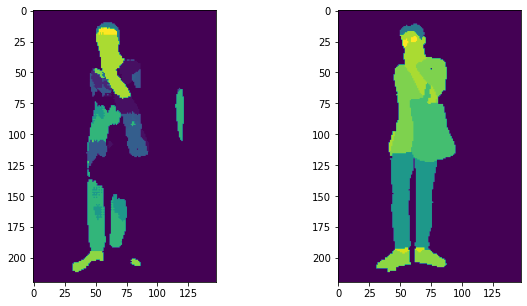

iou: 0.16004483


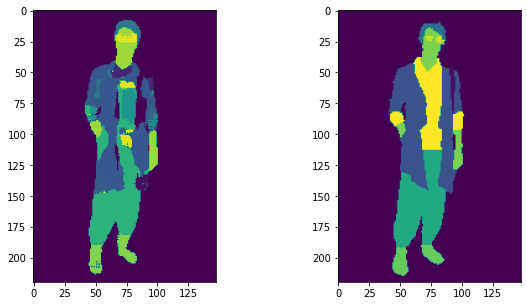

iou: 0.21463375


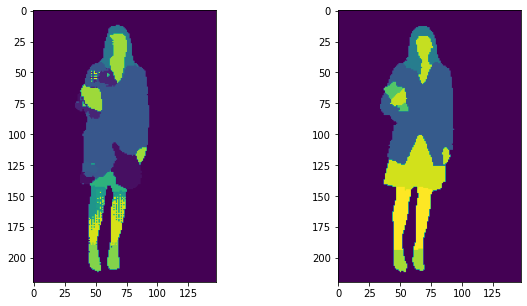

iou: 0.244133


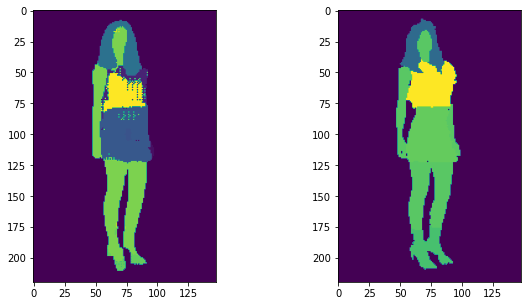

iou: 0.16280314


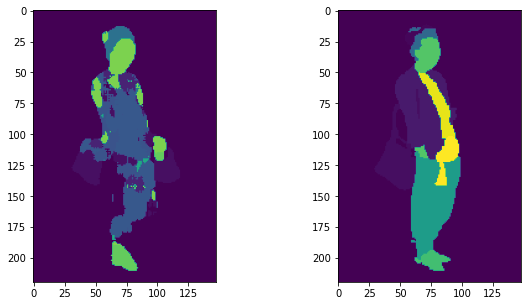

iou: 0.15263355


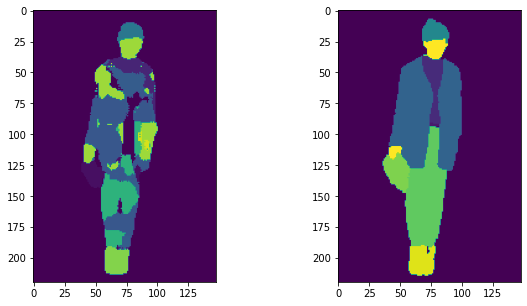

iou: 0.25841558


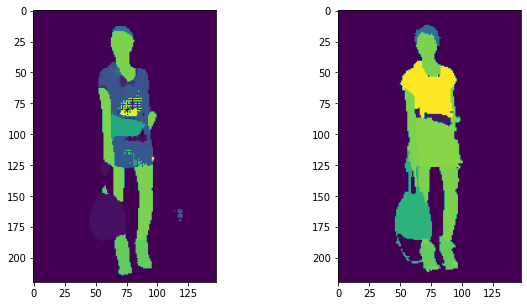

iou: 0.18713194


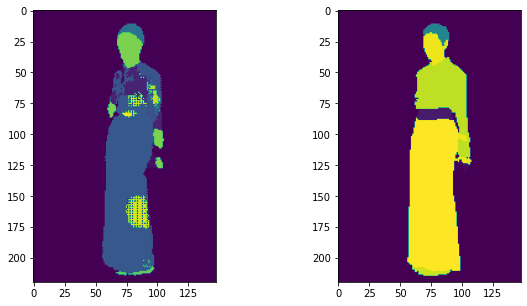

iou: 0.14185852


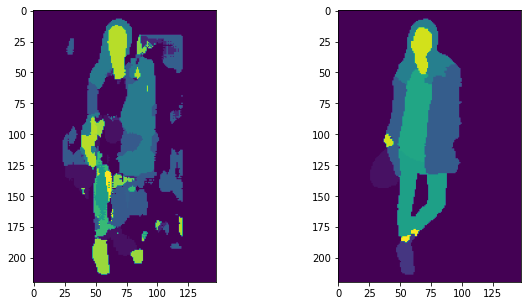

iou: 0.13348326


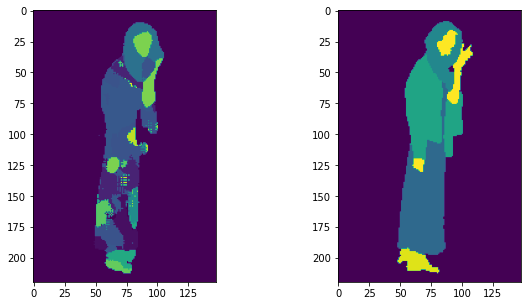

iou: 0.16779451


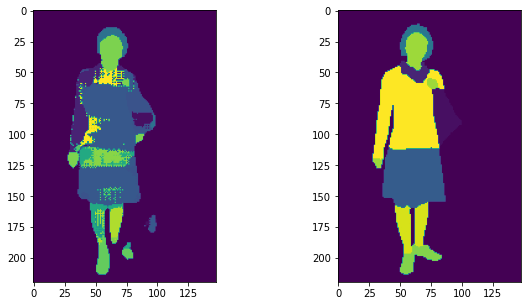

iou: 0.19768612


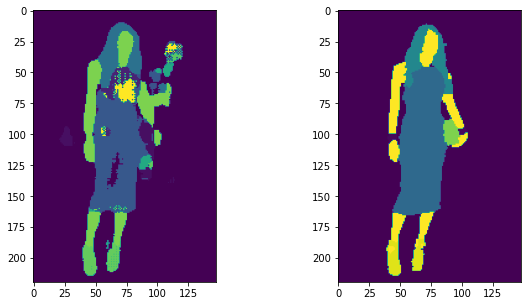

iou: 0.21150406


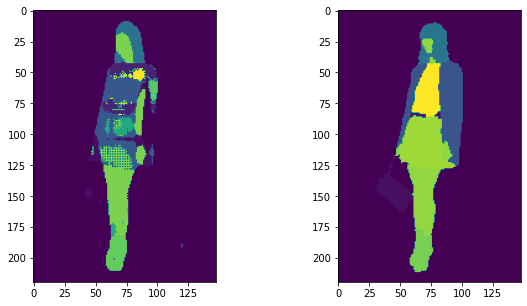

iou: 0.18155937


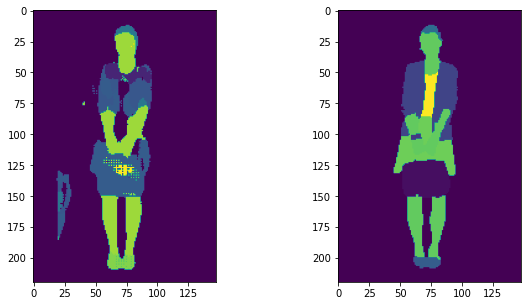

iou: 0.10505809


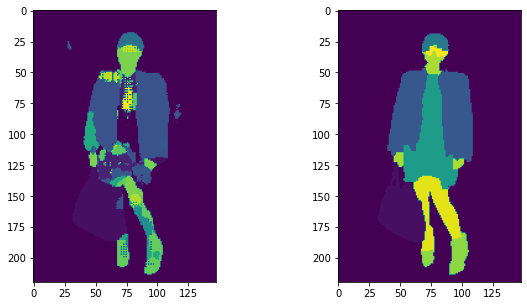

iou: 0.22240555


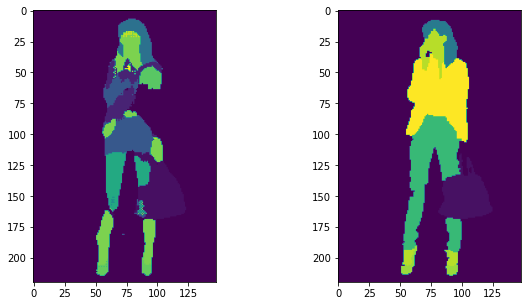

iou: 0.2267353


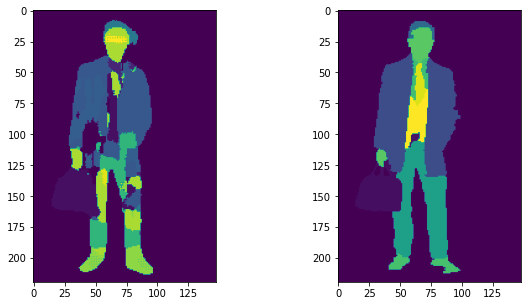

iou: 0.18600768


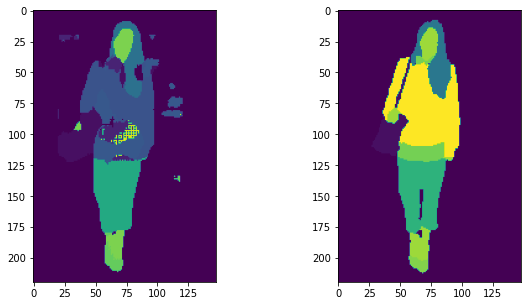

iou: 0.3252101


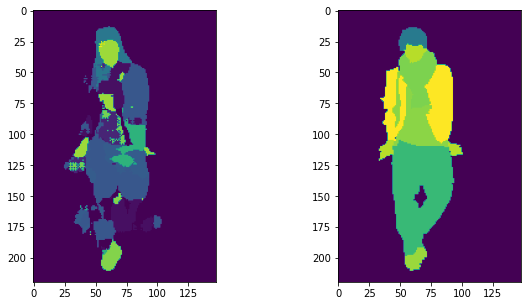

iou: 0.18871275


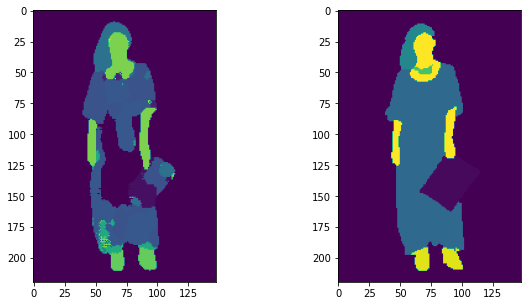

iou: 0.21369252


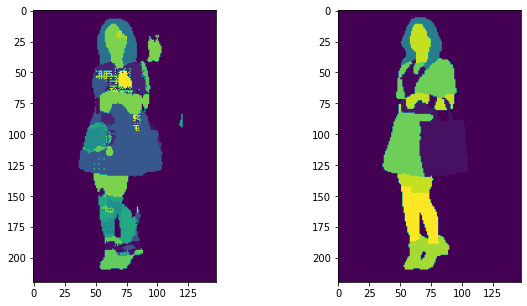

iou: 0.13010798


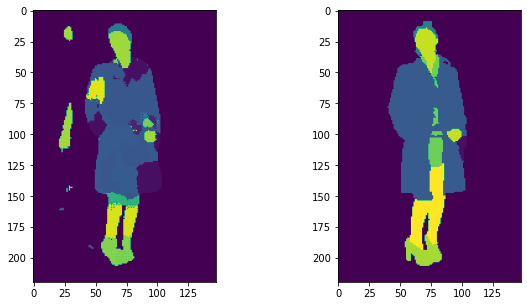

iou: 0.1857854


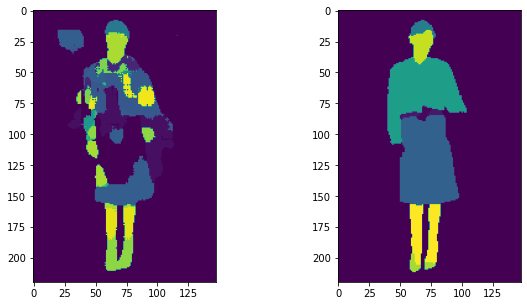

iou: 0.17028321


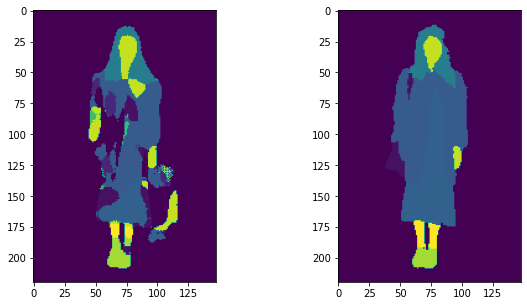

iou: 0.31223944


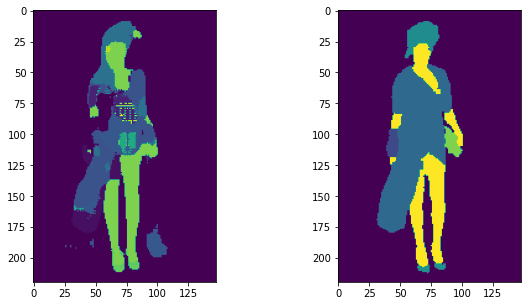

iou: 0.07843813


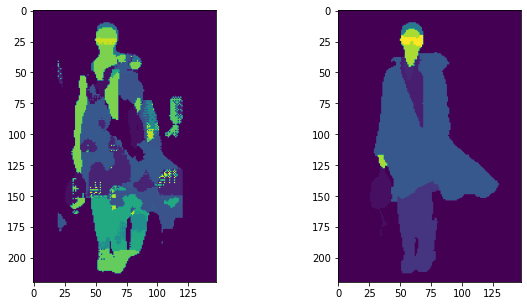

iou: 0.12263903


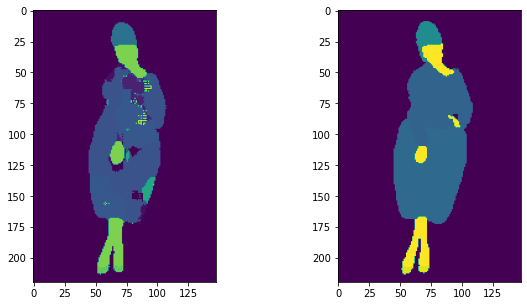

iou: 0.17322567


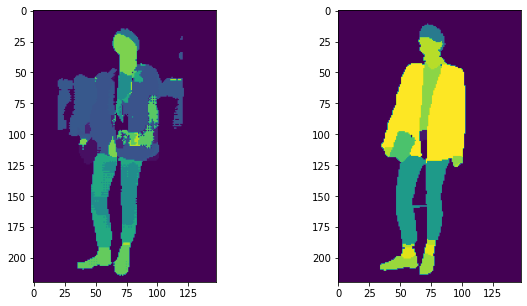

iou: 0.14426632


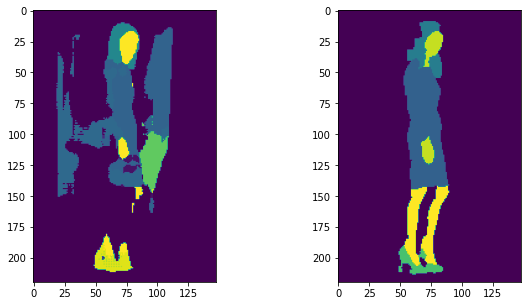

iou: 0.1556373


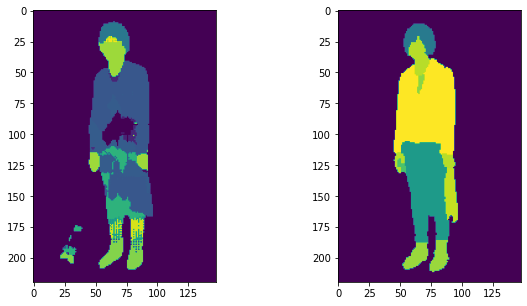

iou: 0.1597954


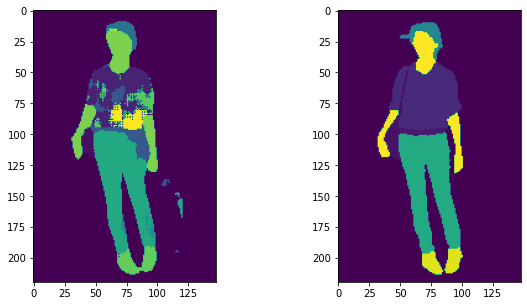

iou: 0.24990648


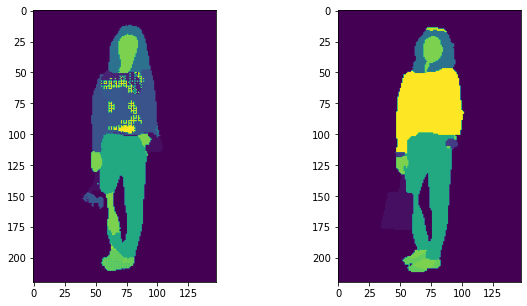

iou: 0.19475712


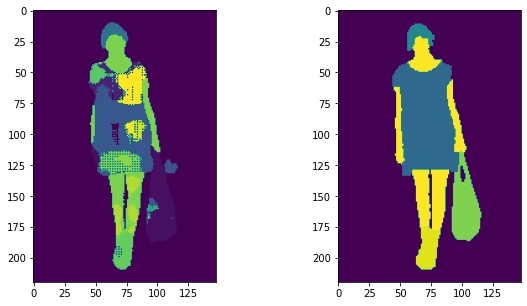

iou: 0.20625763


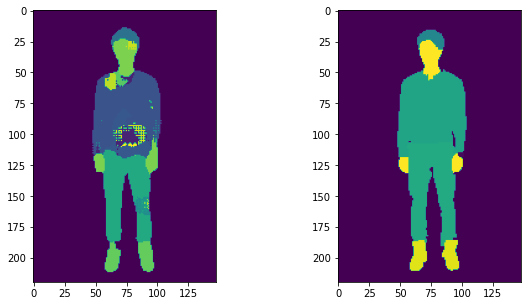

iou: 0.16090229


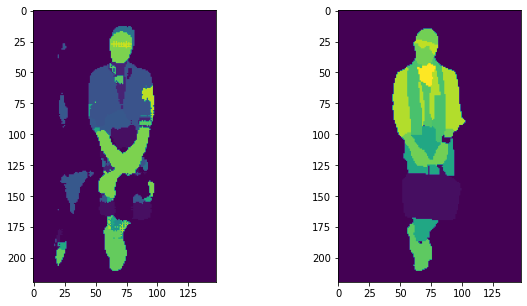

iou: 0.13526598


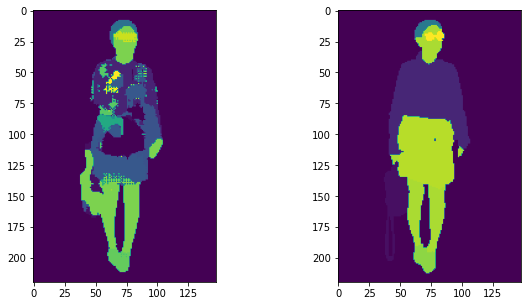

iou: 0.21393548


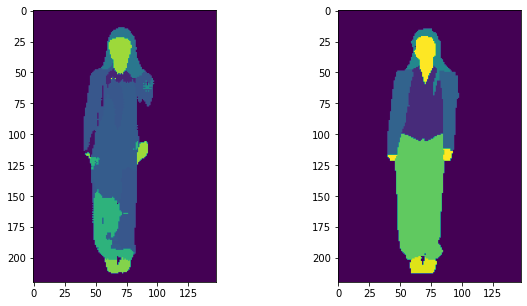

iou: 0.3455663


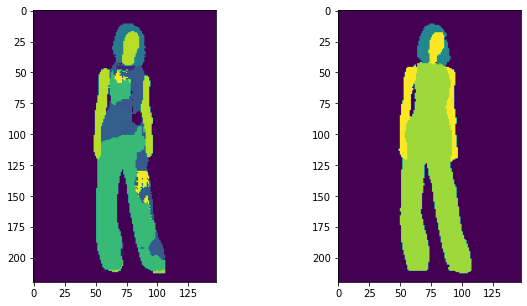

iou: 0.20879221


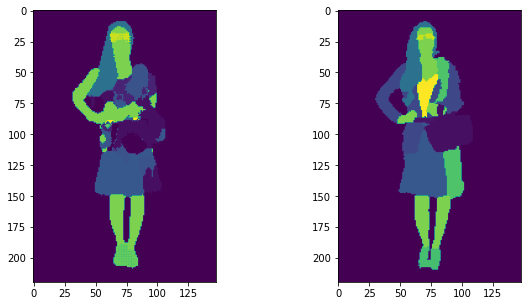

iou: 0.23910427


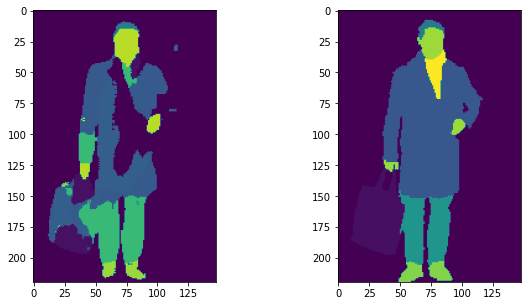

iou: 0.19888799


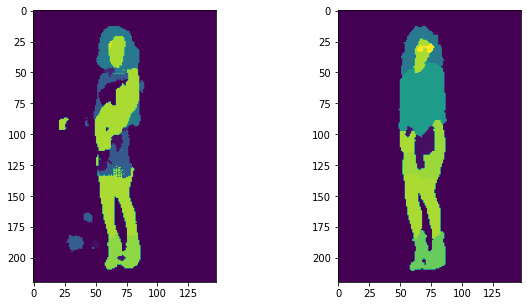

iou: 0.13547704


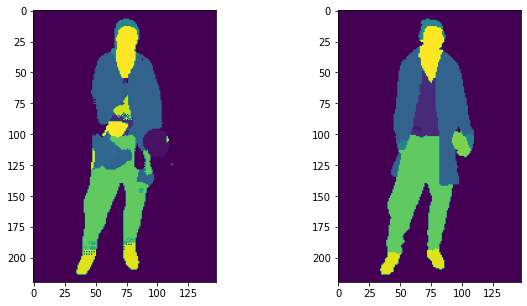

iou: 0.2756738


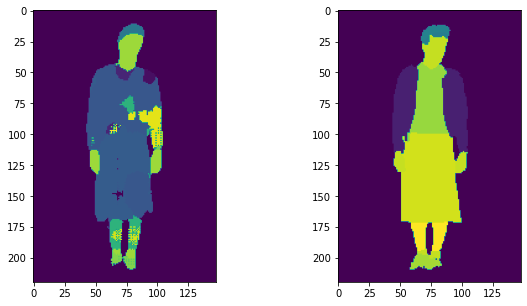

iou: 0.12026428


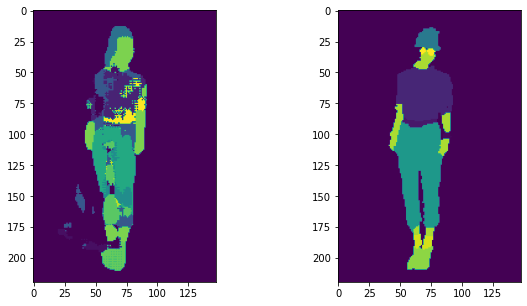

iou: 0.1474679


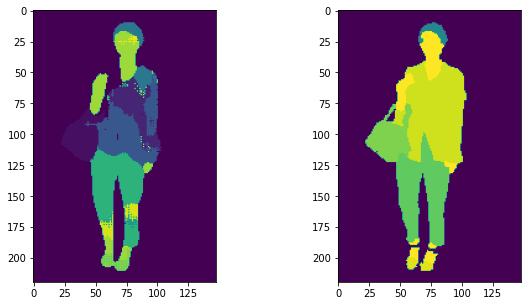

iou: 0.17906632


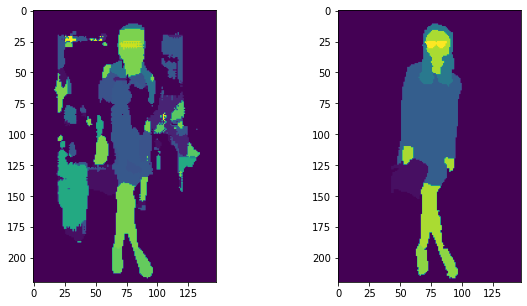

iou: 0.23466685


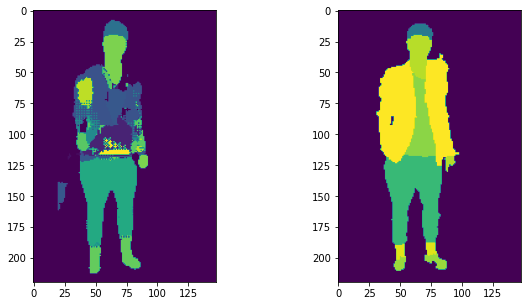

iou: 0.20769791


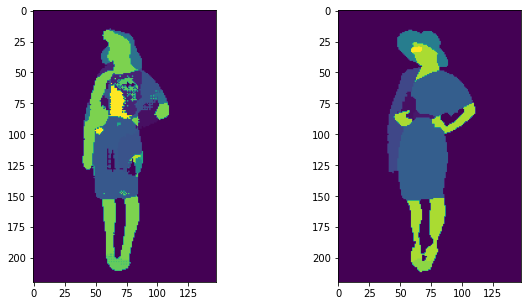

iou: 0.11950762


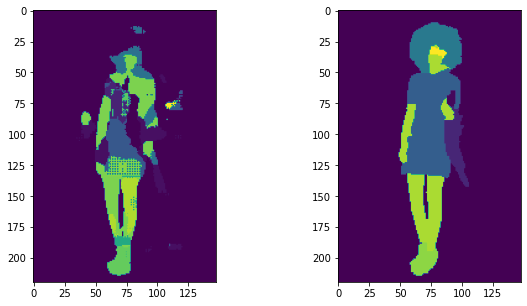

iou: 0.128484


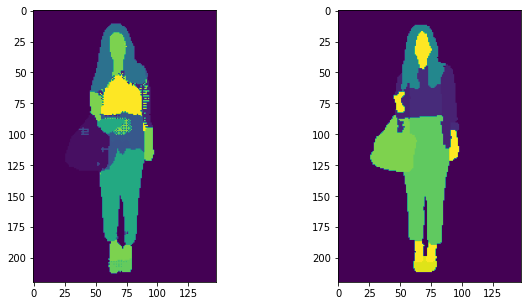

iou: 0.22687279


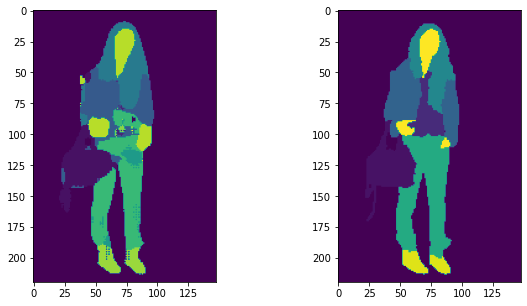

iou: 0.3383082


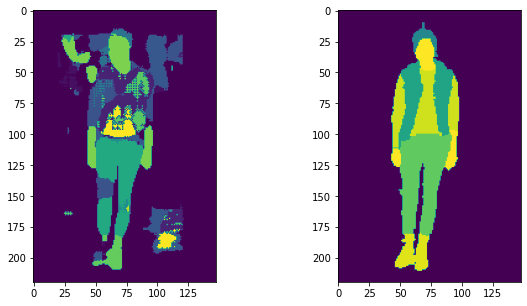

iou: 0.18622734


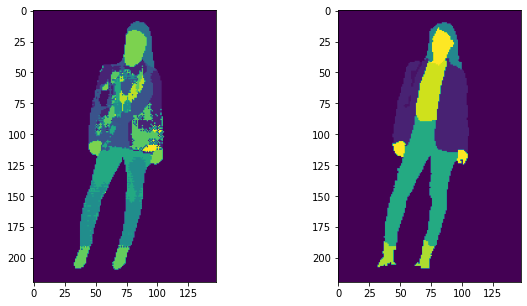

iou: 0.14638826


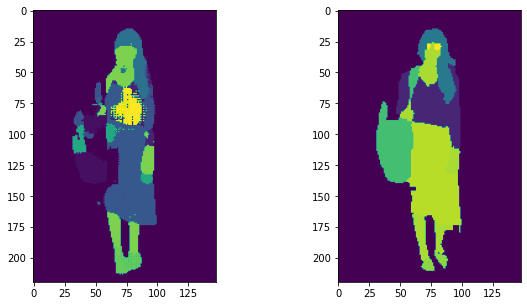

iou: 0.17000316


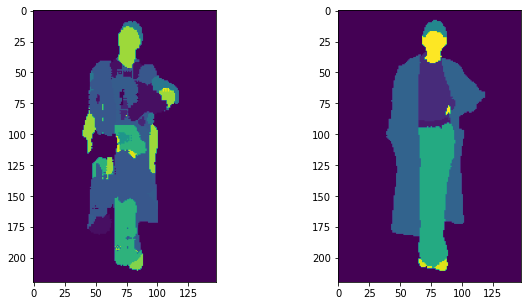

iou: 0.15971617


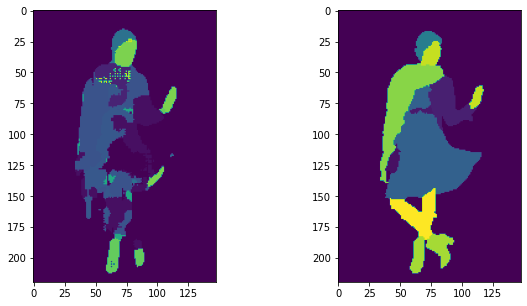

iou: 0.16850391


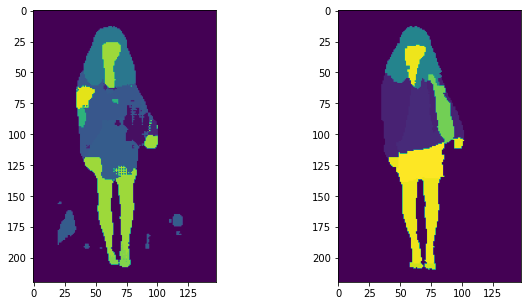

iou: 0.15518898


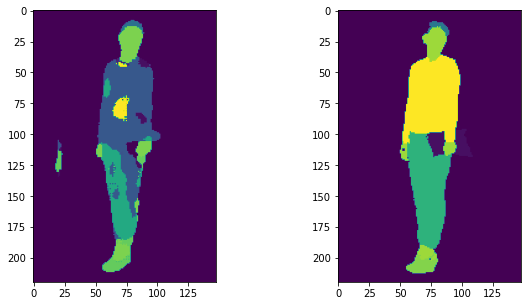

iou: 0.23124324


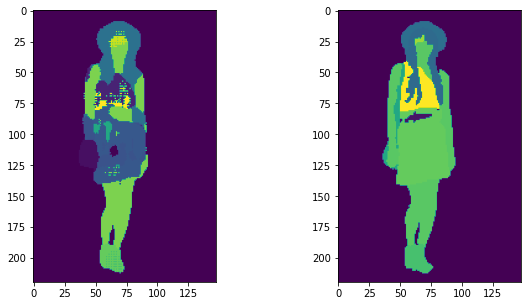

iou: 0.1608249


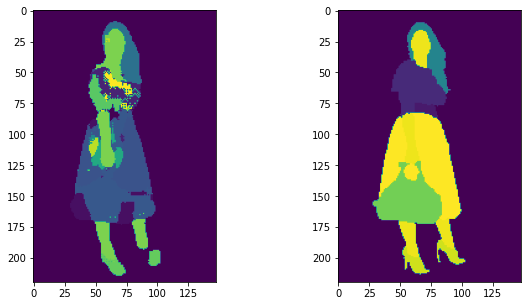

iou: 0.17460275


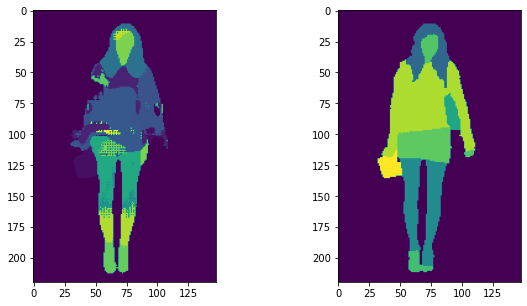

iou: 0.12719399


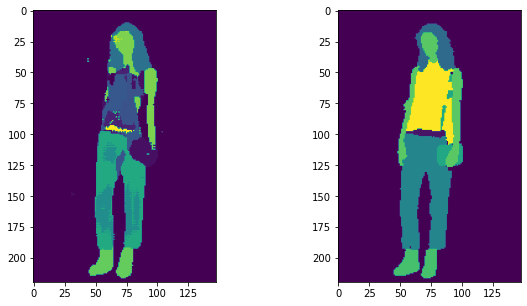

iou: 0.21861865


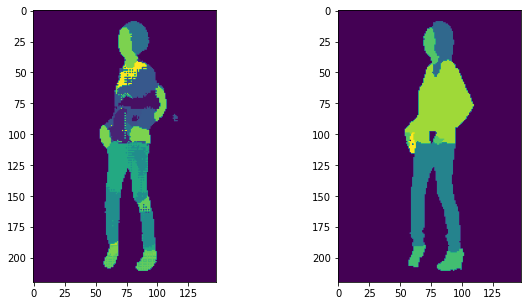

iou: 0.12181055


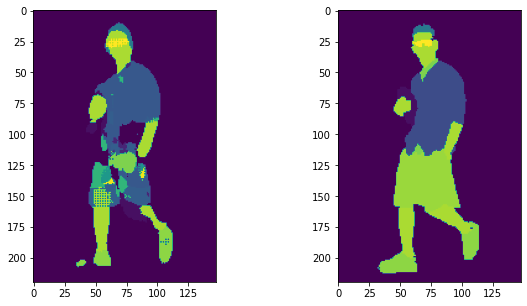

iou: 0.16719466


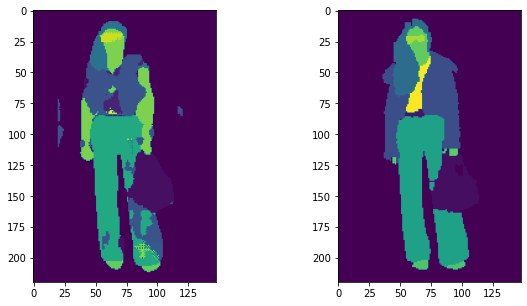

iou: 0.2708844


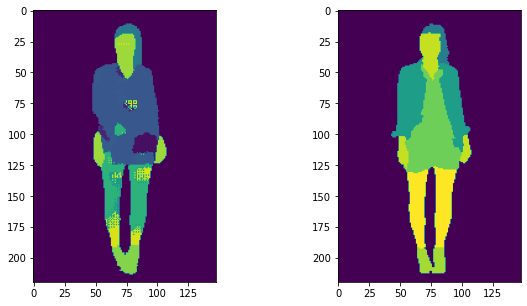

iou: 0.19398044


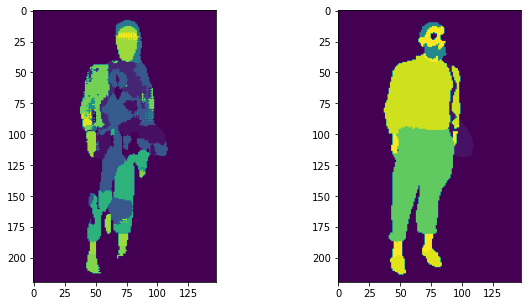

iou: 0.15646198


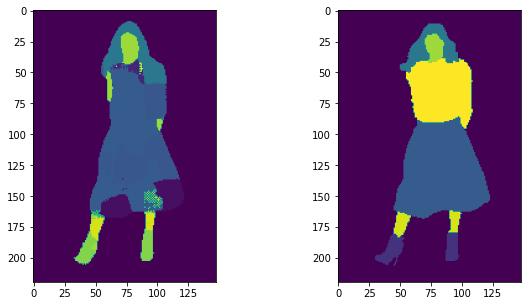

iou: 0.20799345


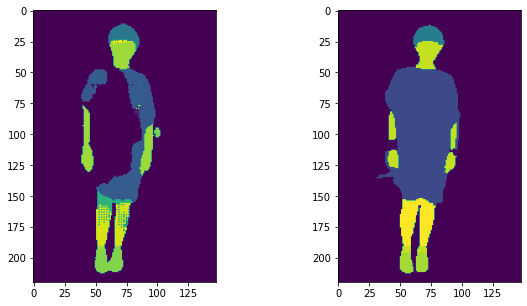

iou: 0.2407758


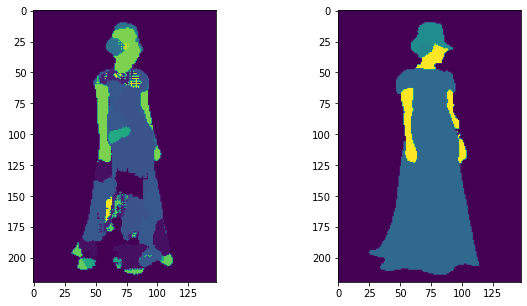

iou: 0.1339716


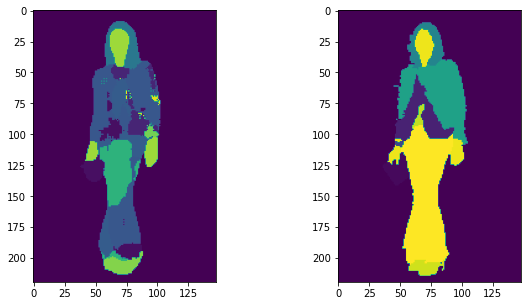

iou: 0.18175593


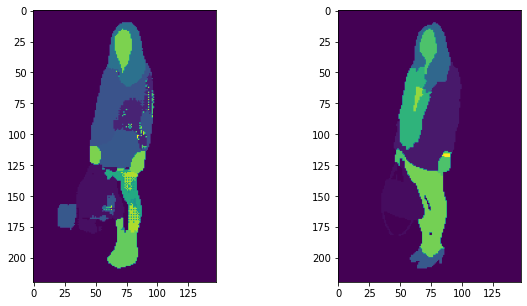

iou: 0.15847073


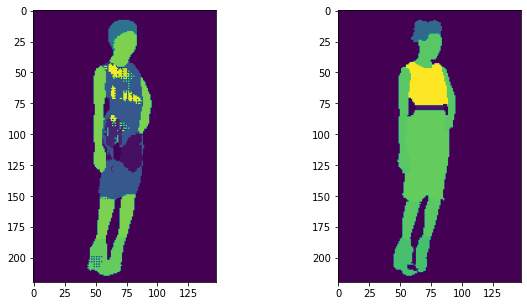

iou: 0.2092599


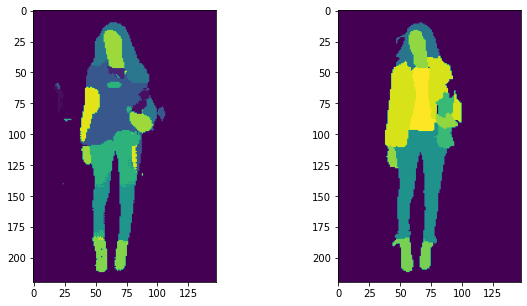

iou: 0.19831656


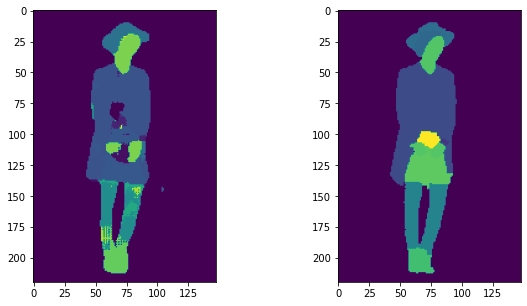

iou: 0.18689762


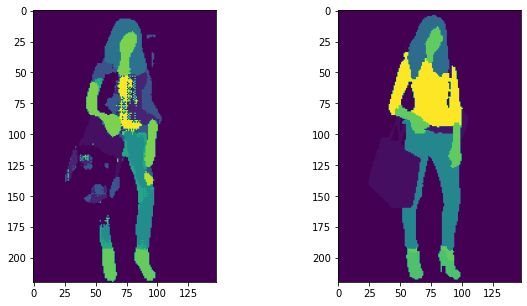

iou: 0.18035875


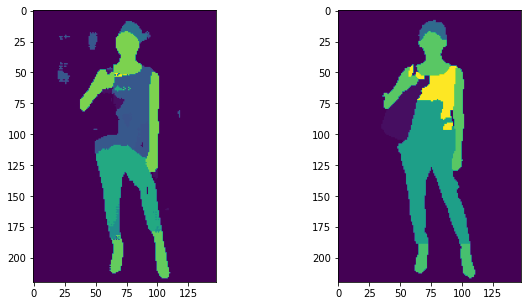

iou: 0.23883906


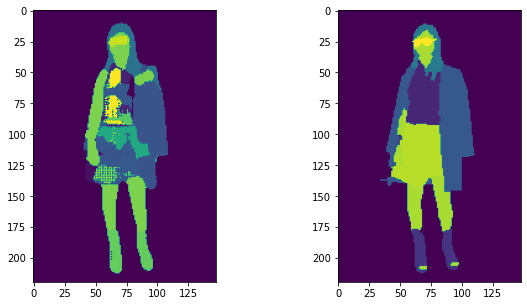

iou: 0.21596566


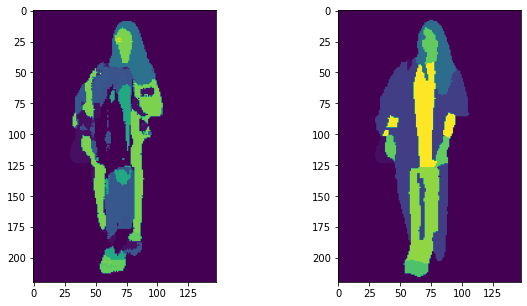

iou: 0.15905347


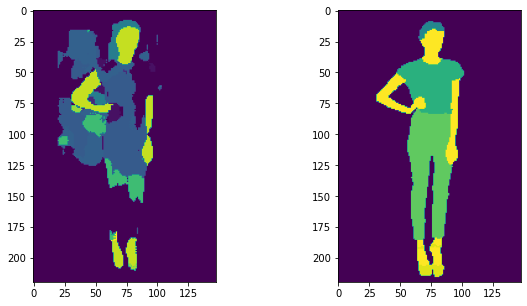

iou: 0.12423086


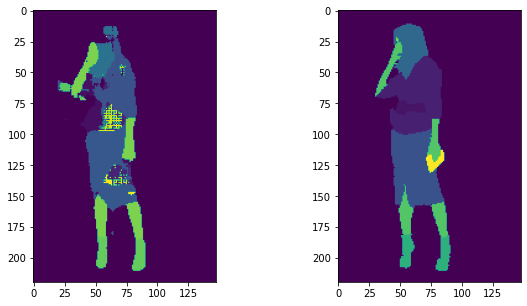

iou: 0.17317083


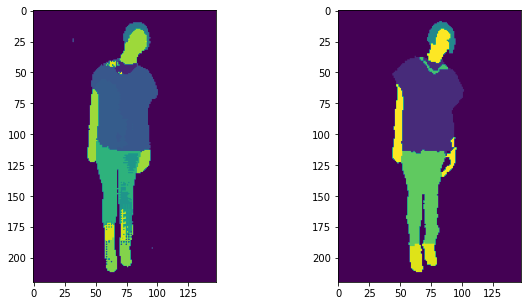

iou: 0.19783989


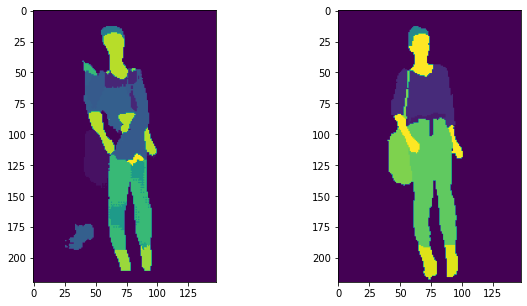

iou: 0.21094124


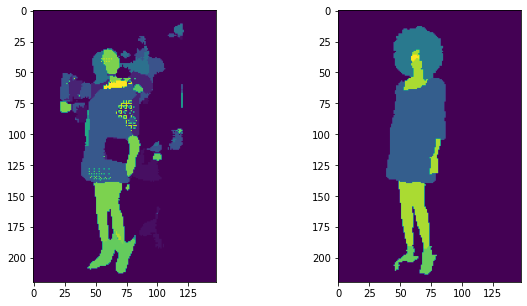

iou: 0.14502148


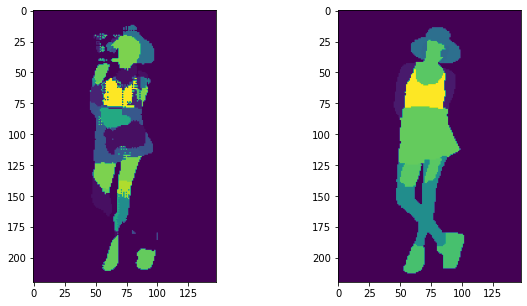

iou: 0.09502769


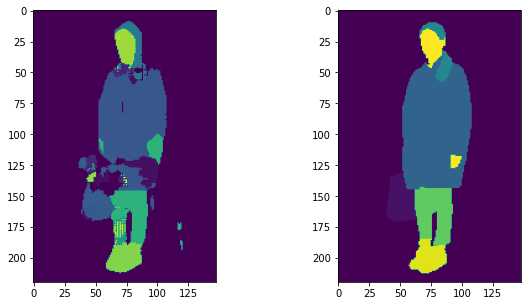

iou: 0.23713449


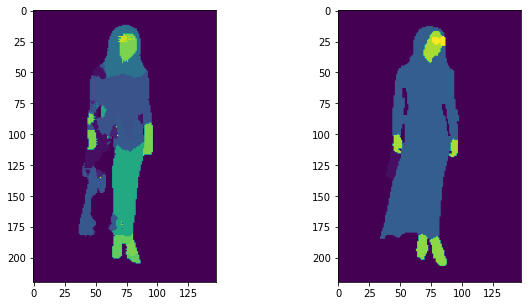

iou: 0.14733827


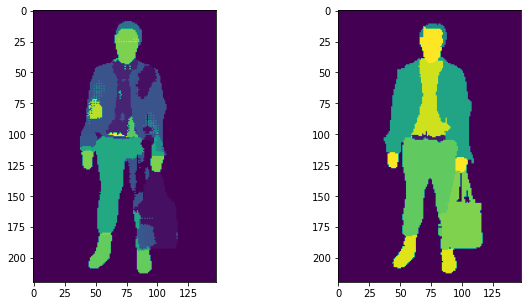

iou: 0.21110761


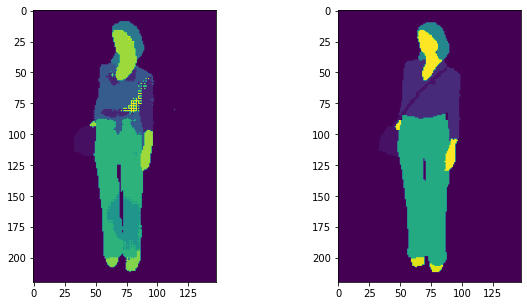

iou: 0.24620947


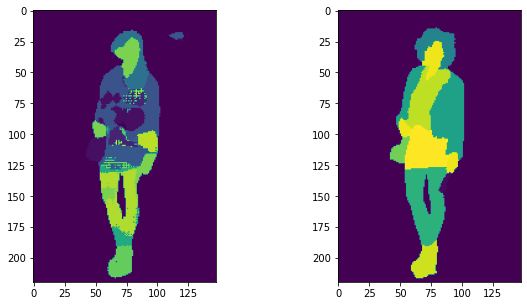

iou: 0.12414538


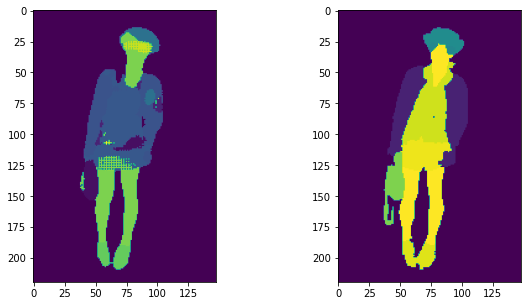

iou: 0.14366487


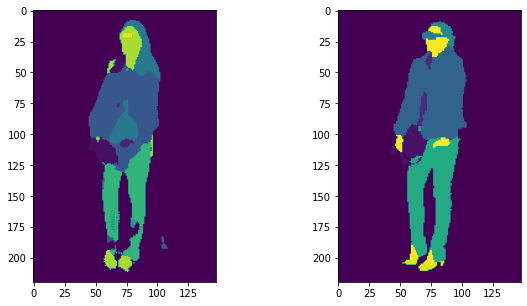

iou: 0.20448792


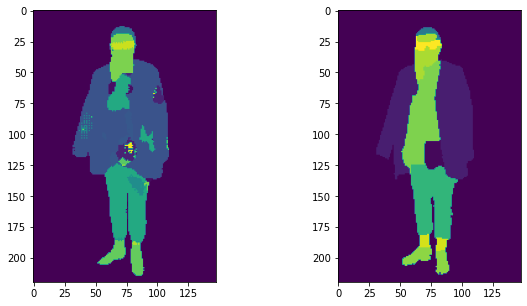

iou: 0.20541725


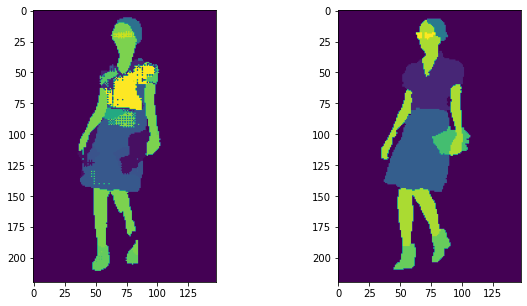

iou: 0.20098121


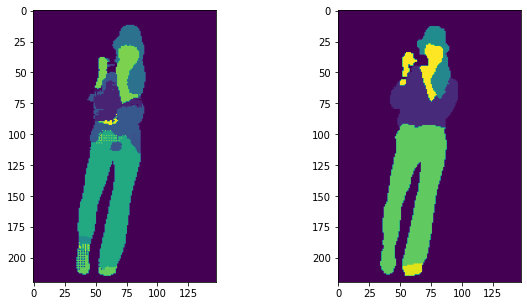

iou: 0.19321239


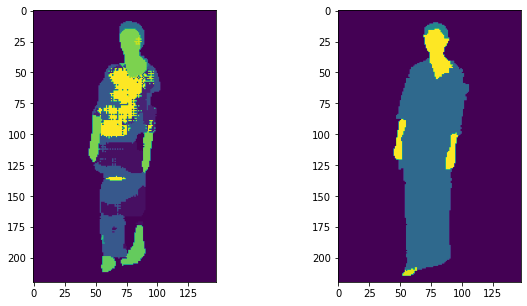

iou: 0.19000925


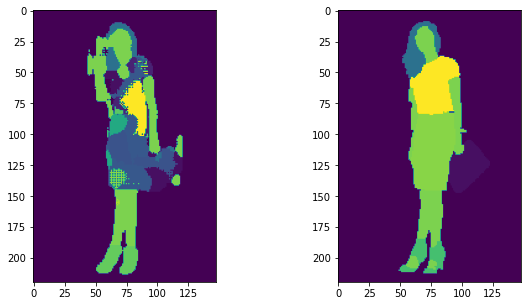

iou: 0.16238071


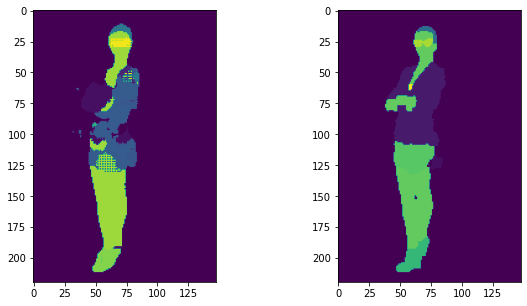

iou: 0.1604667


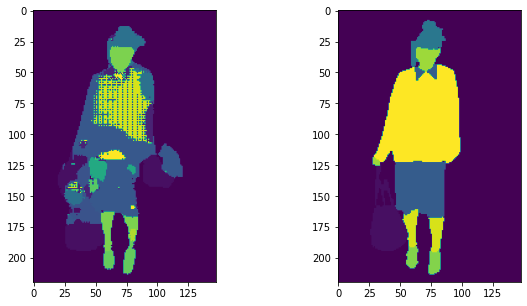

iou: 0.1991001


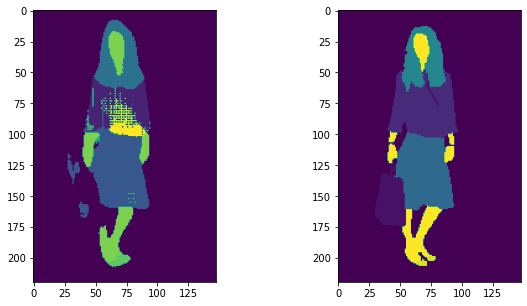

iou: 0.28406593


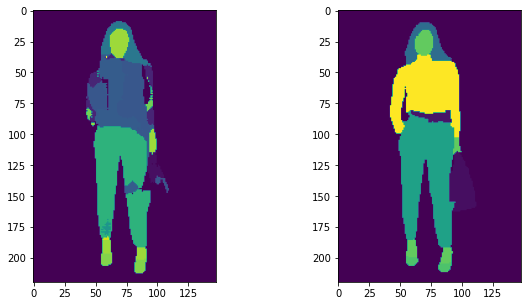

iou: 0.23641907


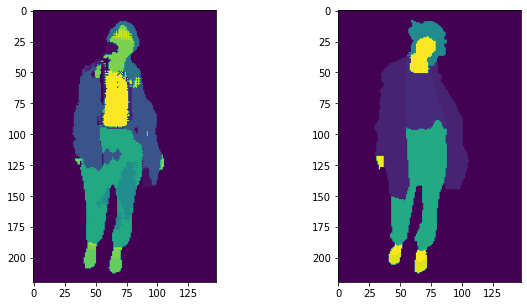

iou: 0.12869962


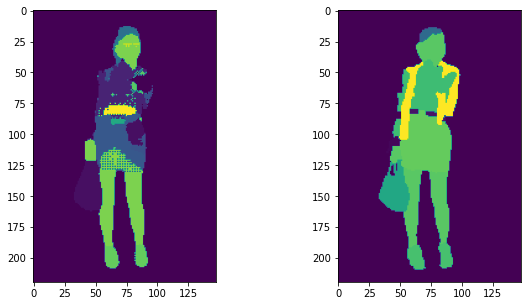

iou: 0.17759831


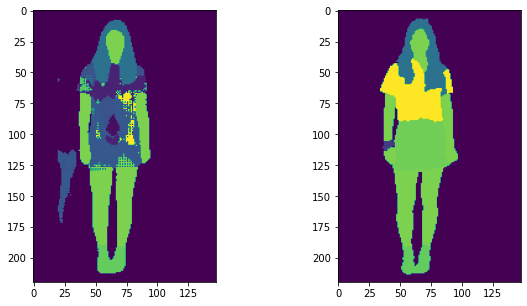

iou: 0.21869363


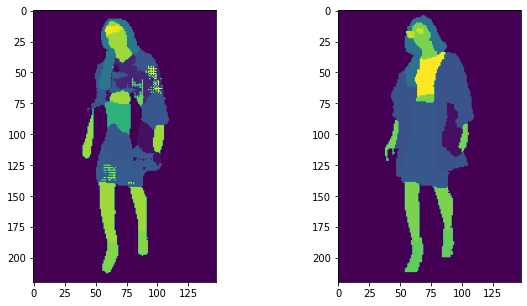

iou: 0.27964532


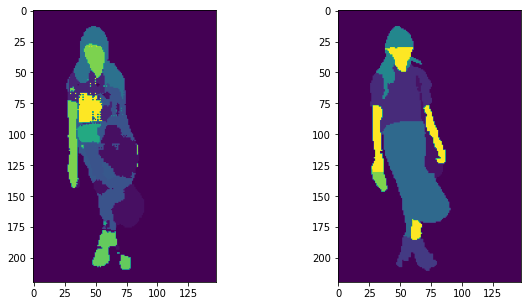

iou: 0.13928953


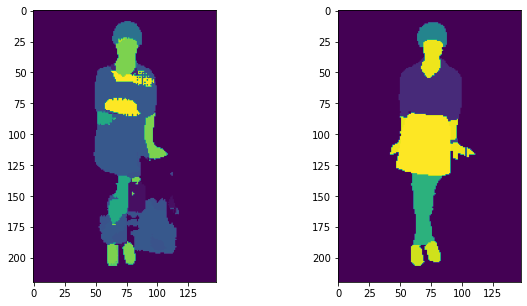

iou: 0.13786007


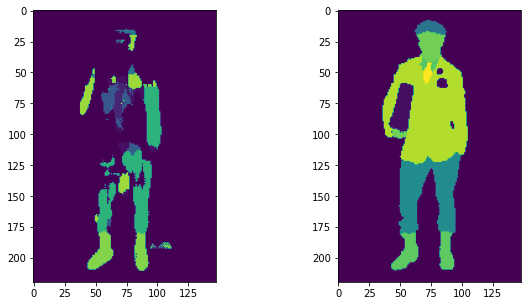

iou: 0.097397394


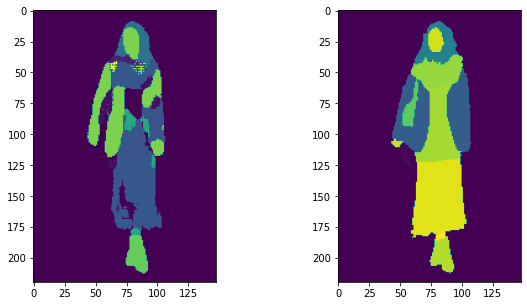

iou: 0.15413953


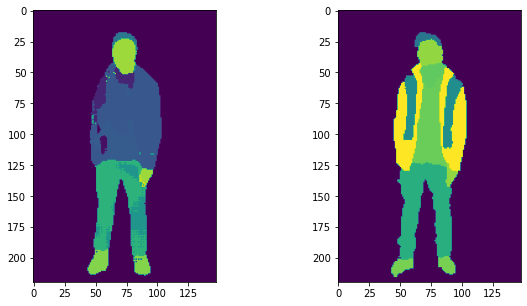

iou: 0.19305807


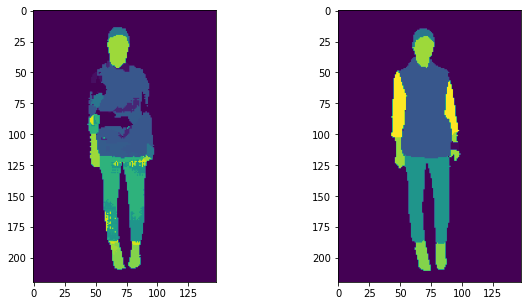

iou: 0.21088213


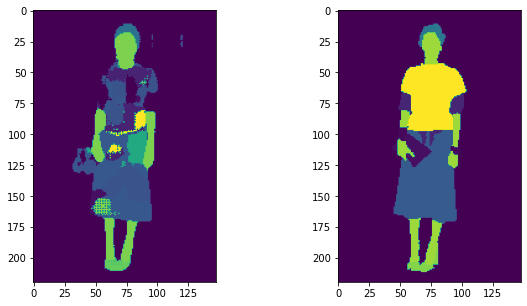

iou: 0.18355809


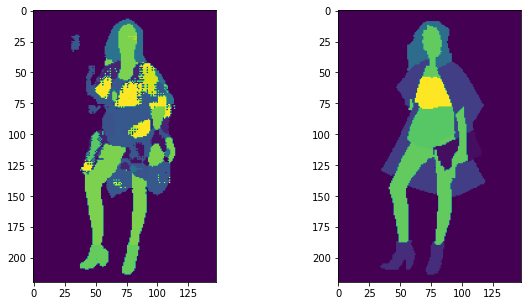

iou: 0.1351507


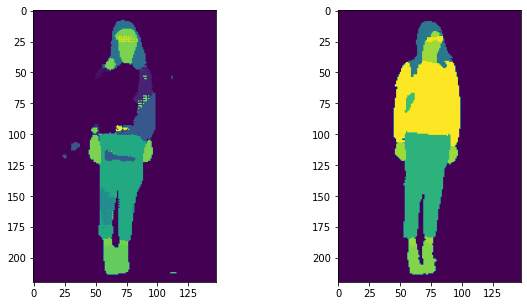

iou: 0.21589375


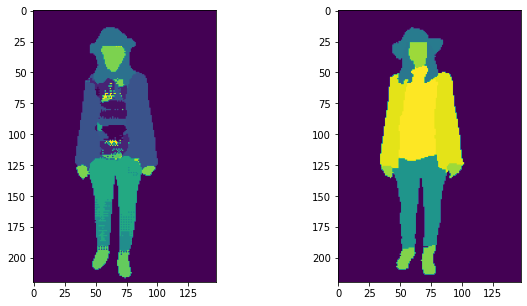

iou: 0.15173453


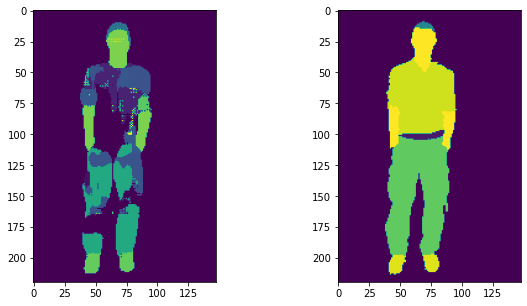

iou: 0.22515702


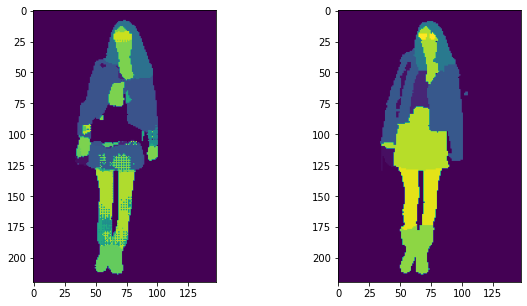

iou: 0.23882073


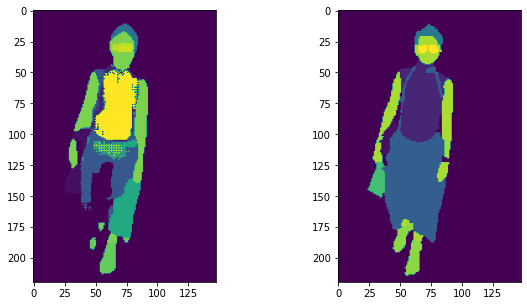

iou: 0.23753949


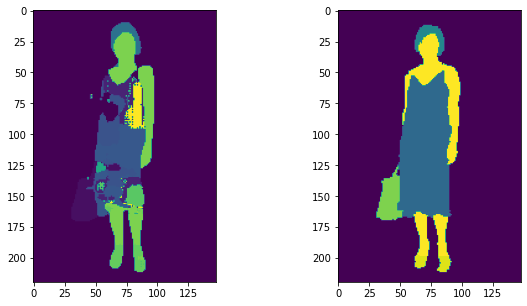

iou: 0.1709528


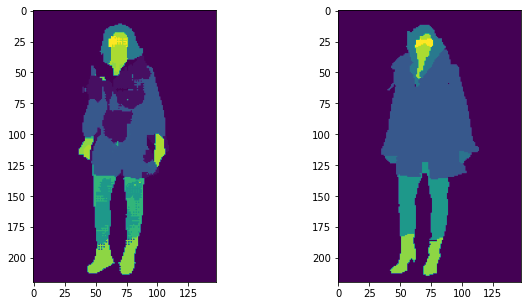

iou: 0.25174507


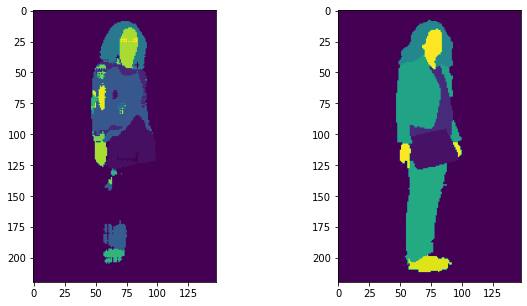

iou: 0.22444355


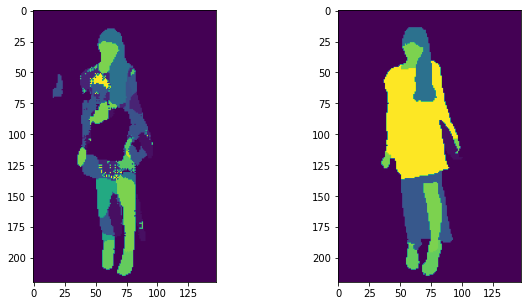

iou: 0.20466727


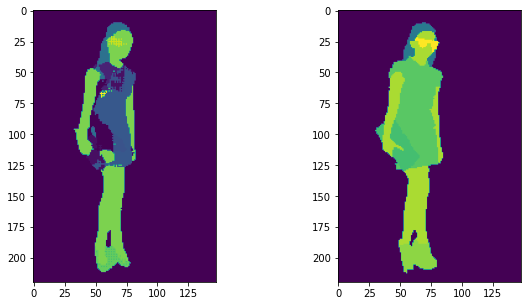

iou: 0.16612326


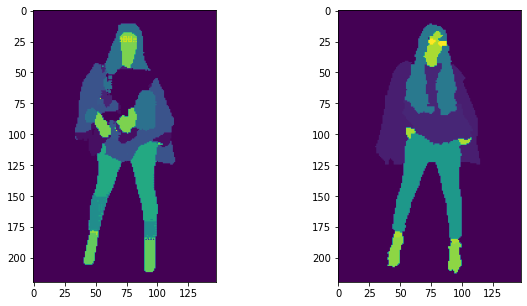

iou: 0.1519688


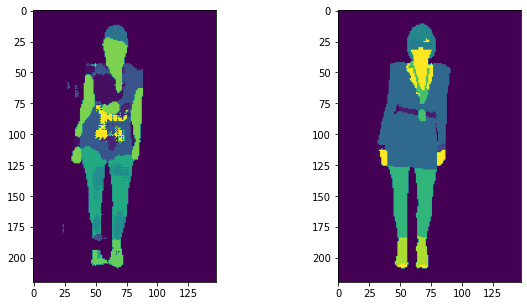

iou: 0.09518289


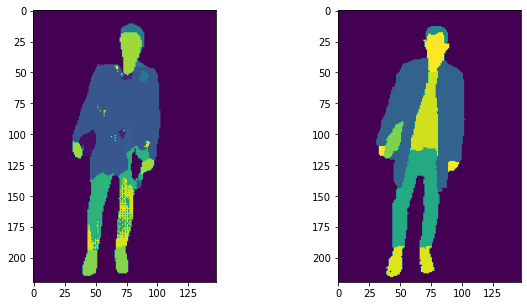

iou: 0.19699876


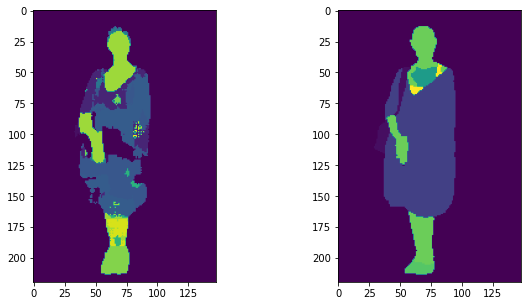

iou: 0.11567317


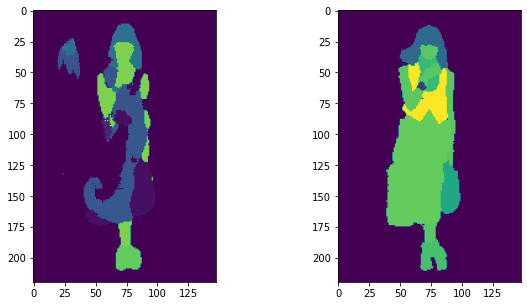

iou: 0.18446088


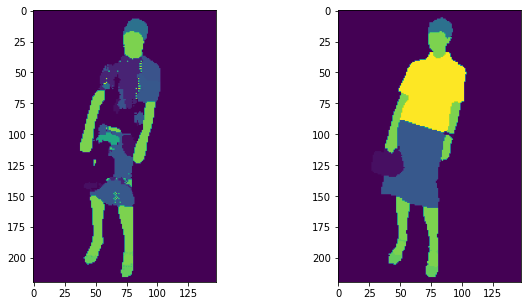

iou: 0.21366328


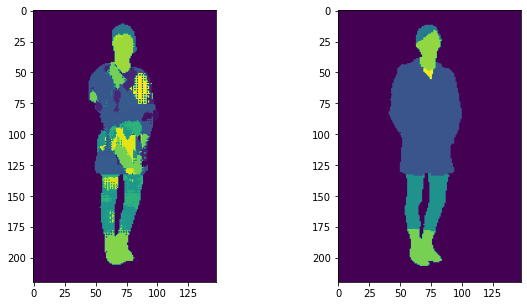

iou: 0.17229047


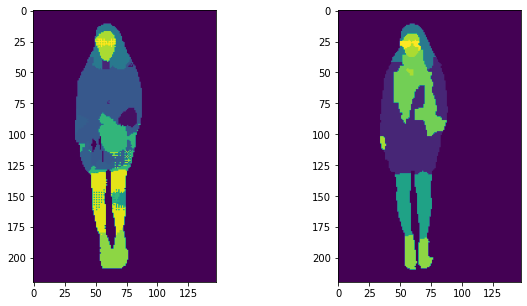

iou: 0.19997817


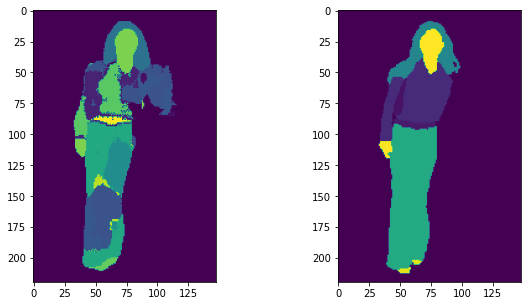

iou: 0.22146095


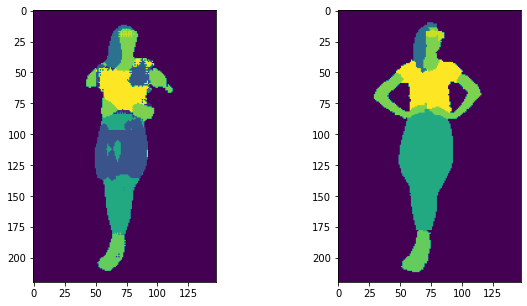

iou: 0.20977461


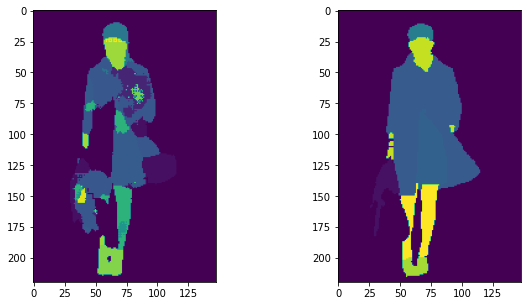

iou: 0.21747951


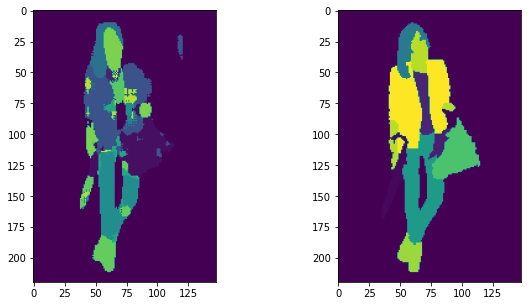

iou: 0.1770757


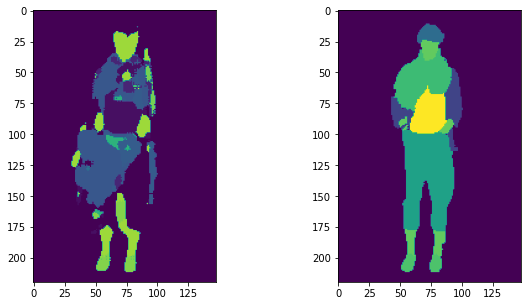

iou: 0.11752935


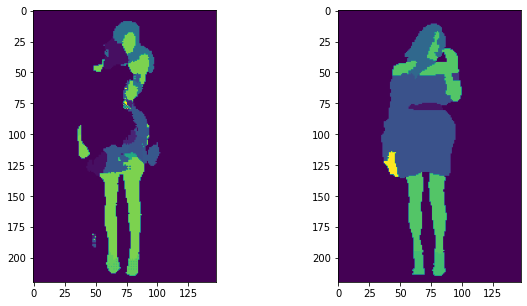

iou: 0.1466899


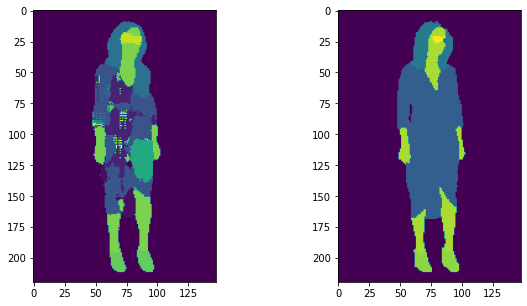

iou: 0.21435235


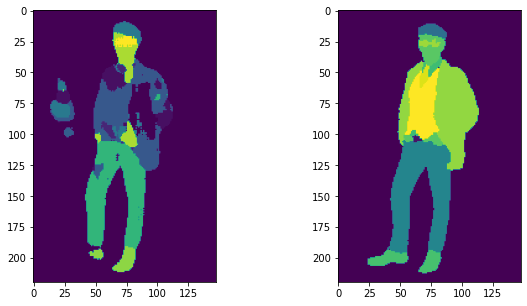

iou: 0.12908177


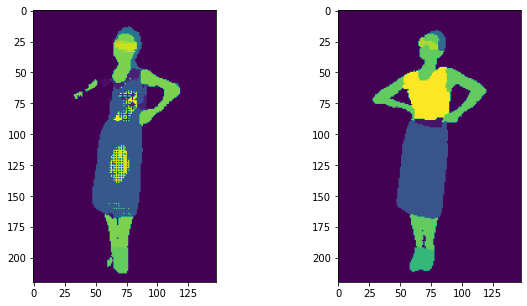

iou: 0.20553637


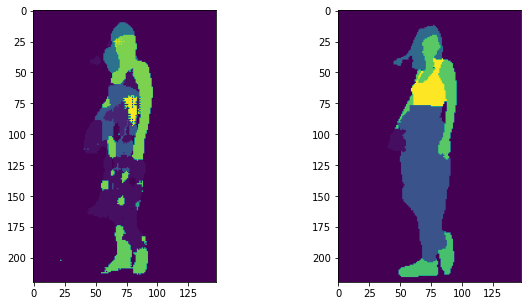

iou: 0.18866065


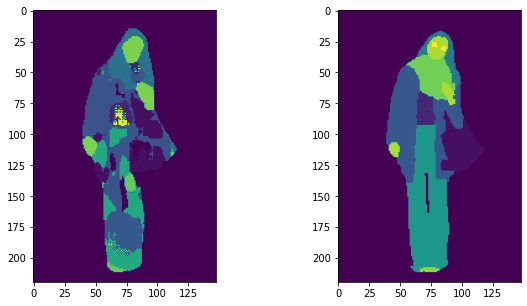

iou: 0.17902586


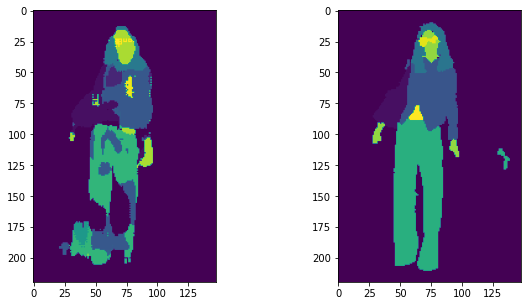

iou: 0.24494487


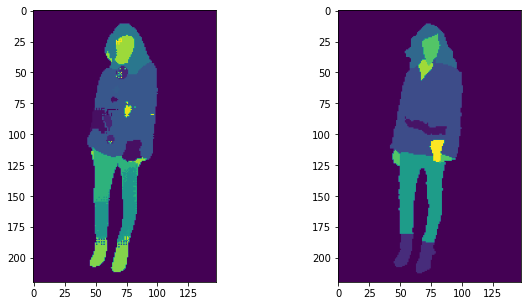

iou: 0.19276088


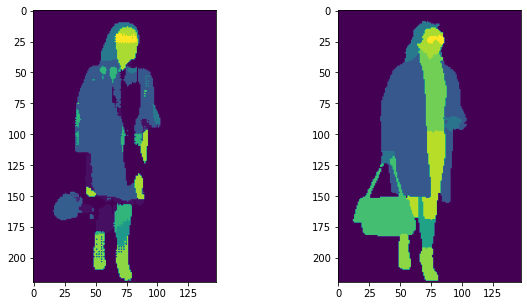

iou: 0.1877549


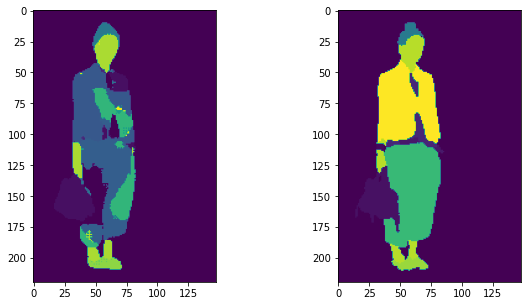

iou: 0.22483854


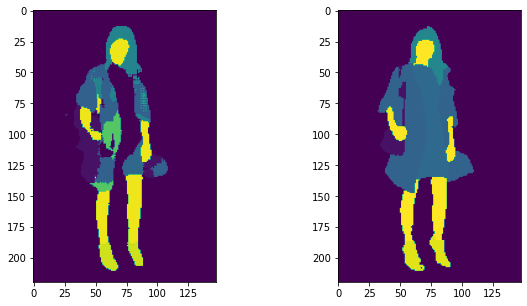

iou: 0.3243642


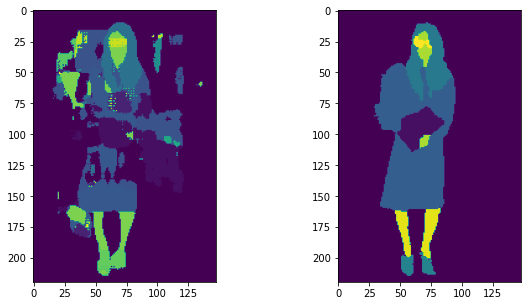

iou: 0.13785765


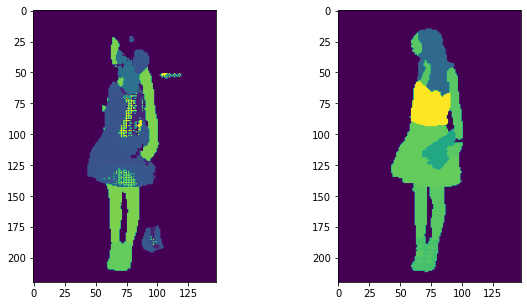

iou: 0.18229742


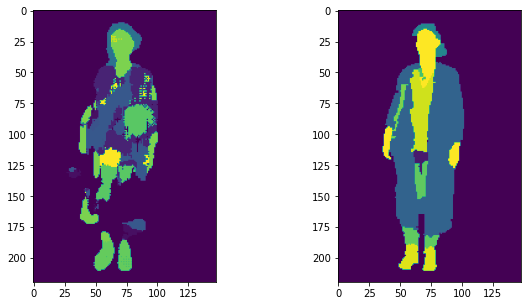

iou: 0.14537746


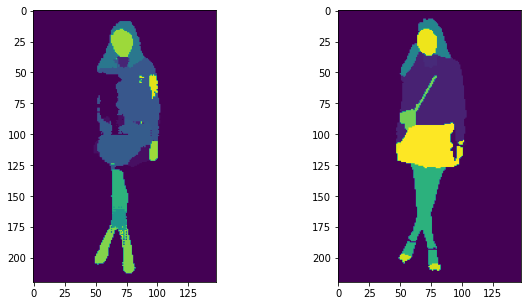

iou: 0.14913504


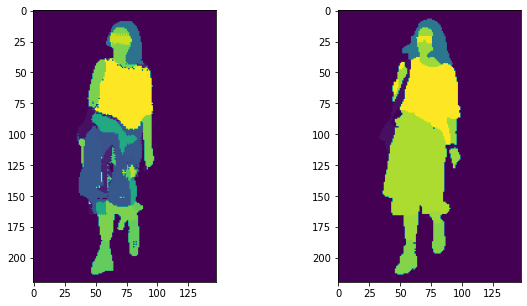

iou: 0.18754527


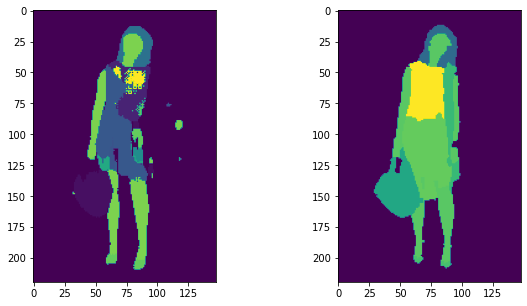

iou: 0.1445486


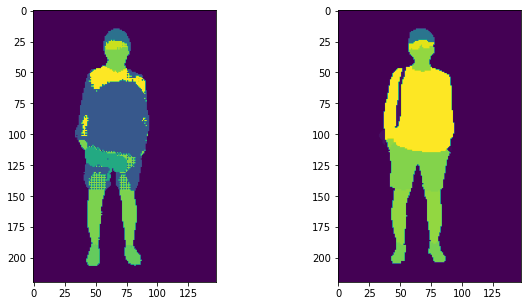

iou: 0.23417675


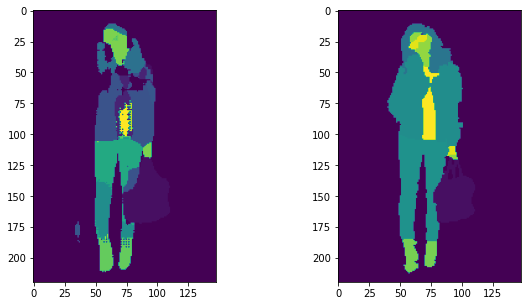

iou: 0.18009593


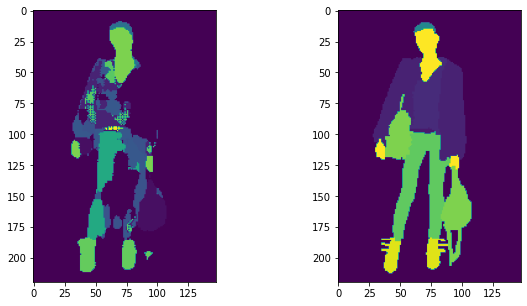

iou: 0.2589714


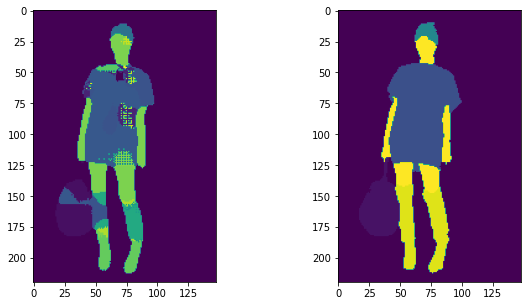

iou: 0.189277


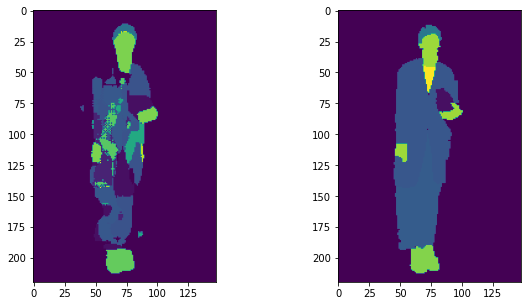

iou: 0.24517831


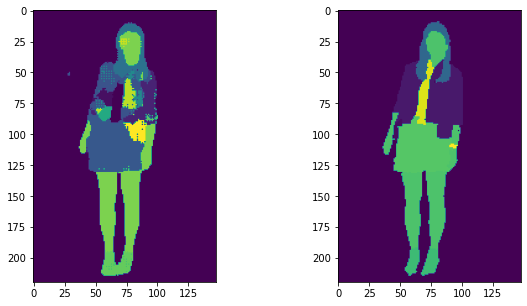

iou: 0.15404017


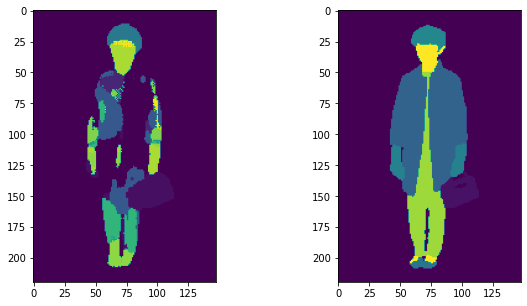

iou: 0.14606106


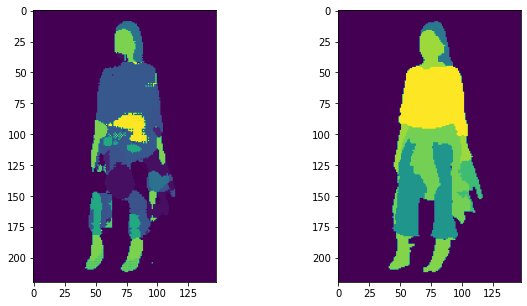

iou: 0.11513007


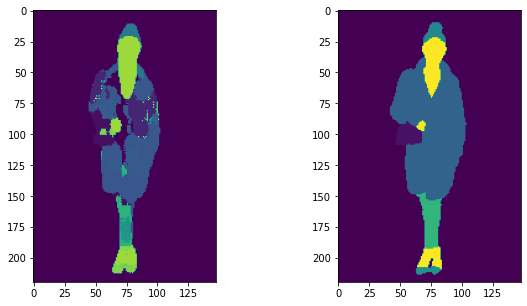

iou: 0.17272303


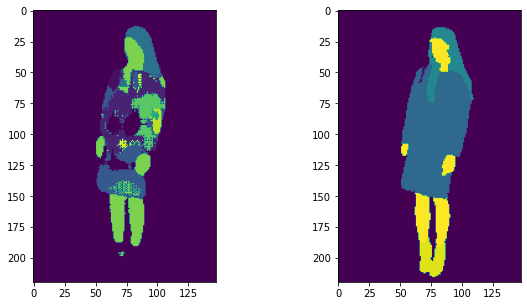

iou: 0.1664275


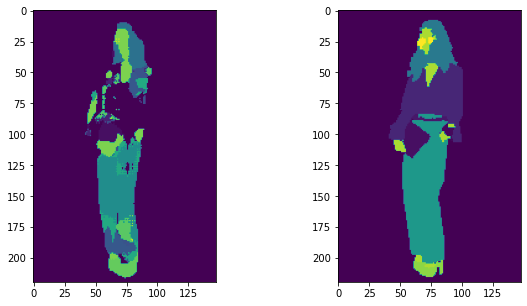

iou: 0.17695683


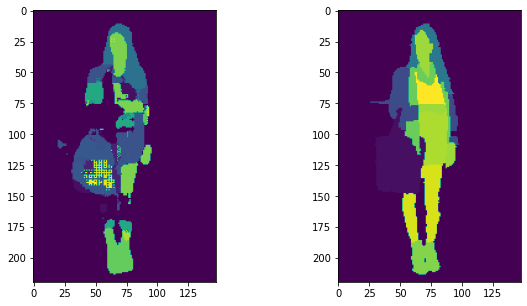

iou: 0.13548617


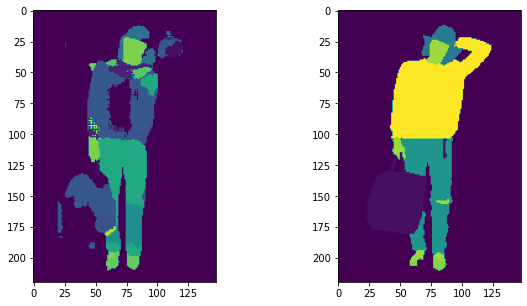

iou: 0.14456809


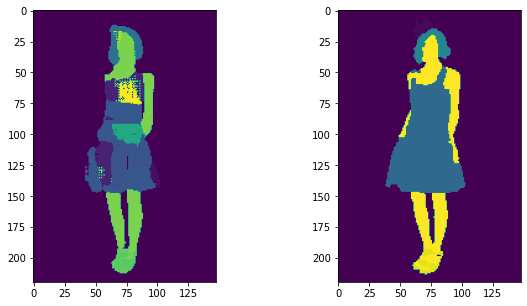

iou: 0.1928823


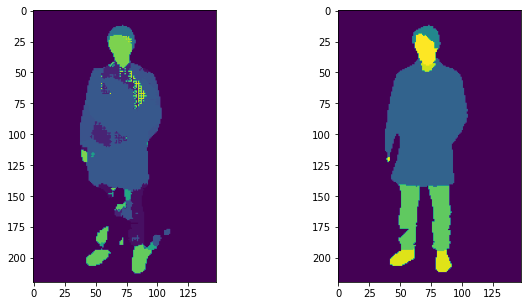

iou: 0.22317752


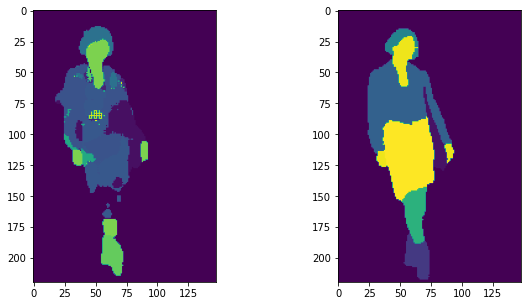

iou: 0.17004749


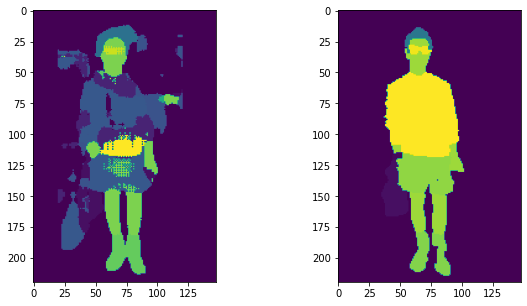

iou: 0.22509123


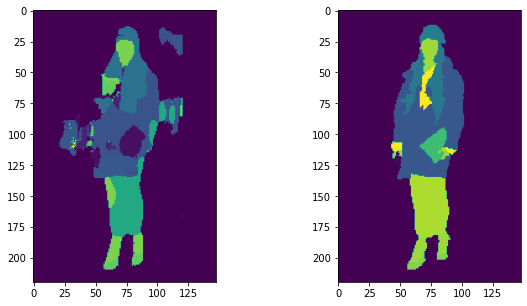

iou: 0.14078838


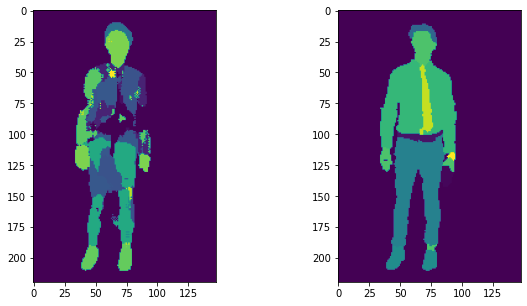

iou: 0.11609613


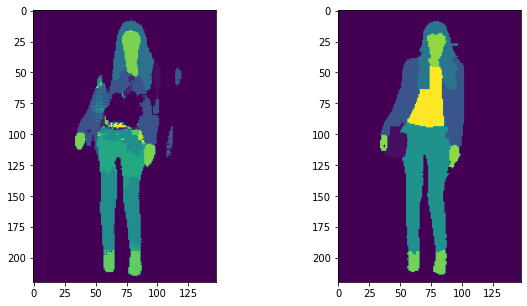

iou: 0.2087309


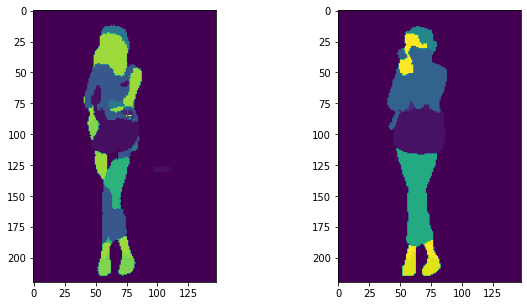

iou: 0.23024185


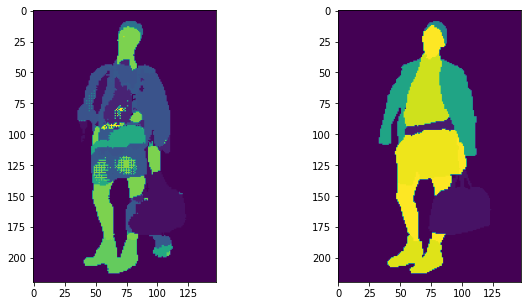

iou: 0.21901251


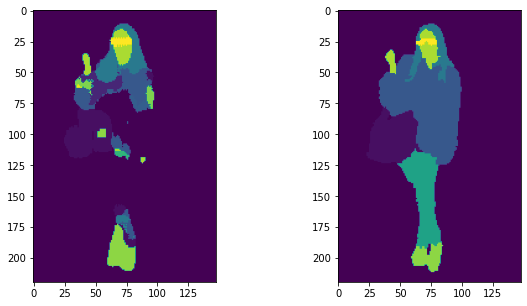

iou: 0.29354525


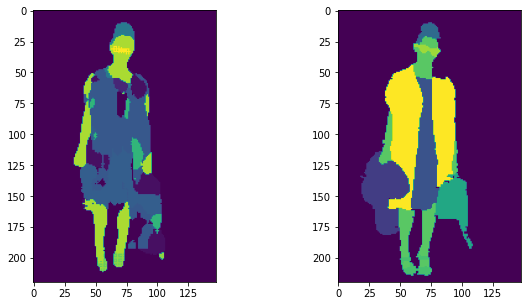

iou: 0.19977508


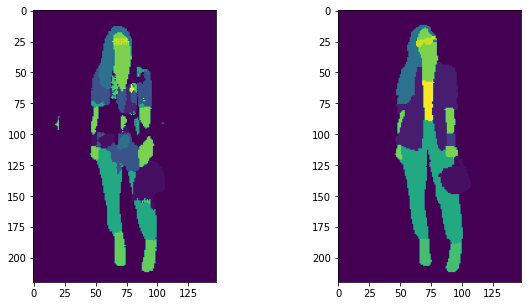

iou: 0.19521473


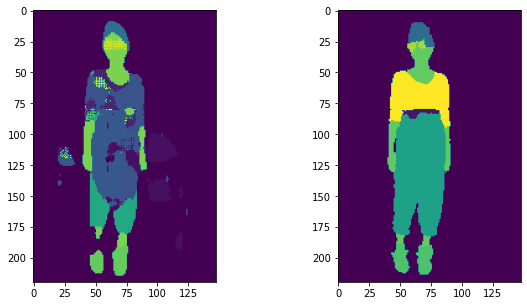

iou: 0.18861789


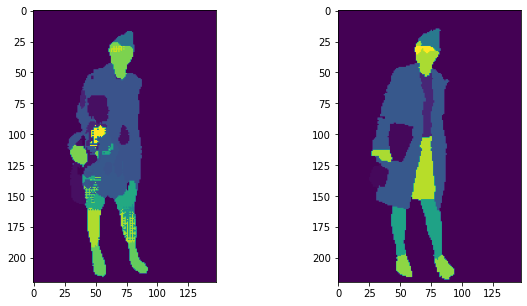

iou: 0.22147624


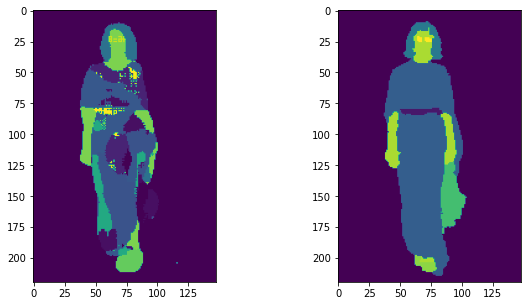

iou: 0.1897586


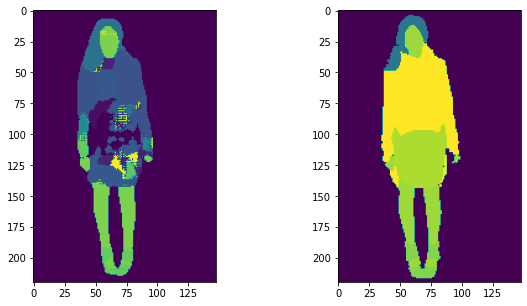

iou: 0.12978306


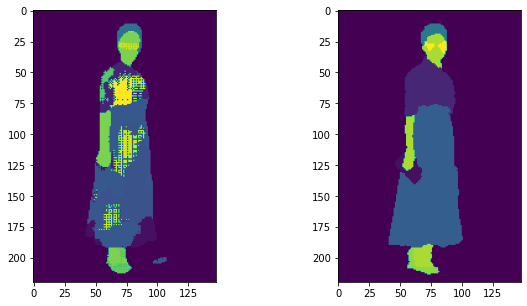

iou: 0.26126024


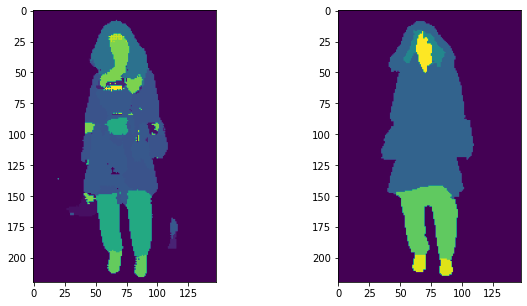

iou: 0.22223683


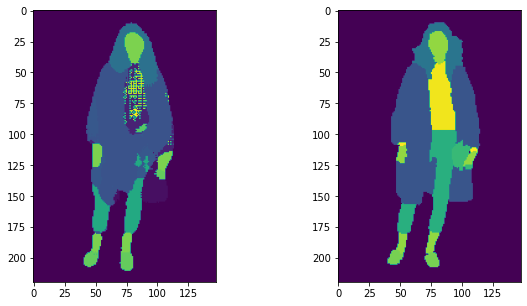

iou: 0.26764643


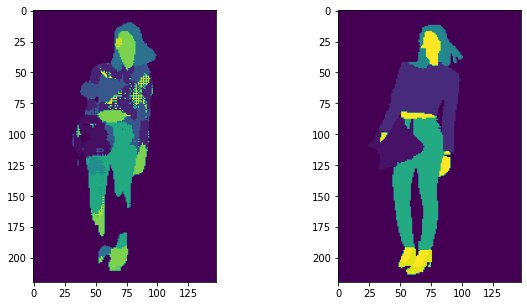

iou: 0.15627034


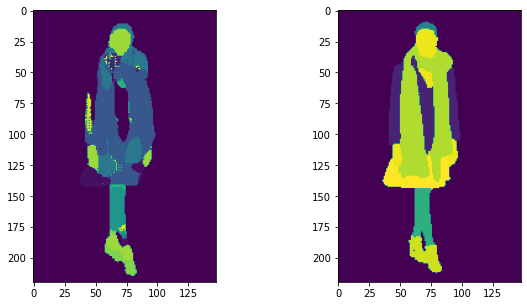

iou: 0.099791065


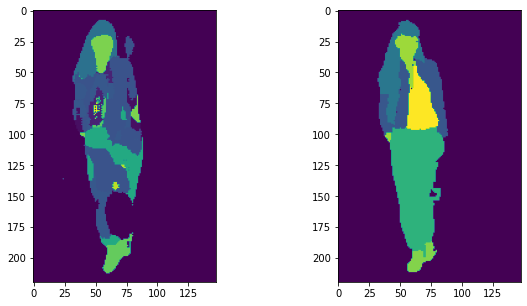

iou: 0.20283799


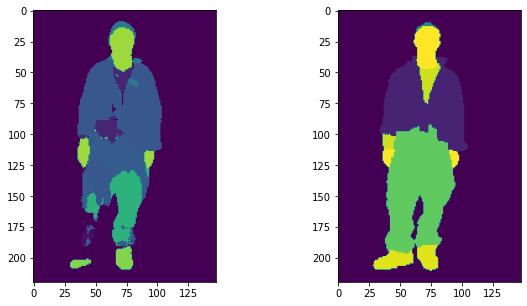

iou: 0.22657157


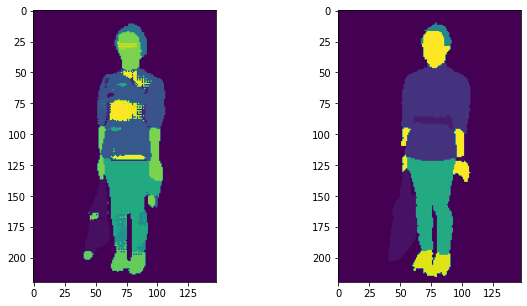

iou: 0.16896728


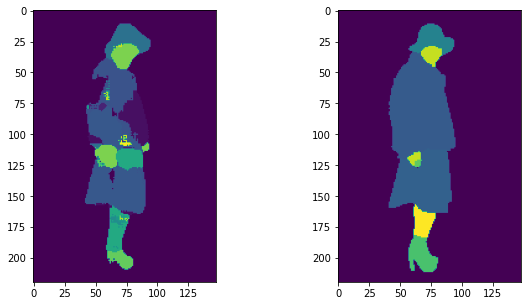

iou: 0.102871984


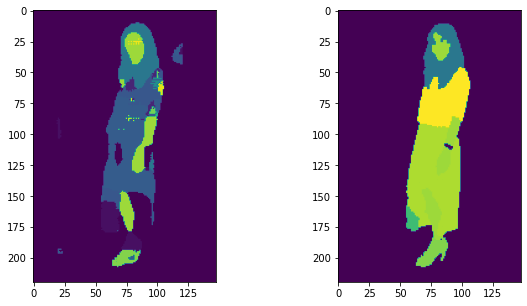

iou: 0.15935603


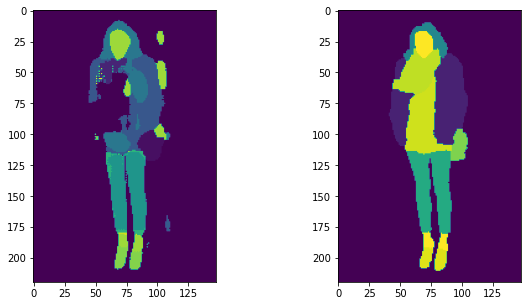

iou: 0.18619768


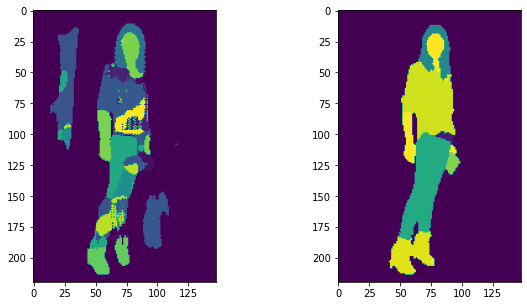

iou: 0.15572166


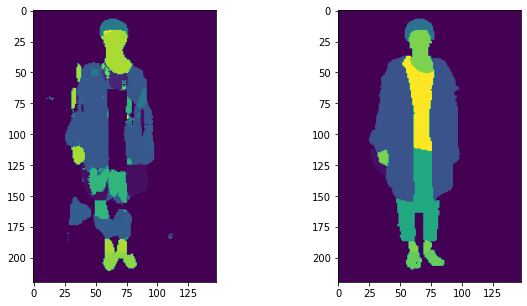

iou: 0.2110087


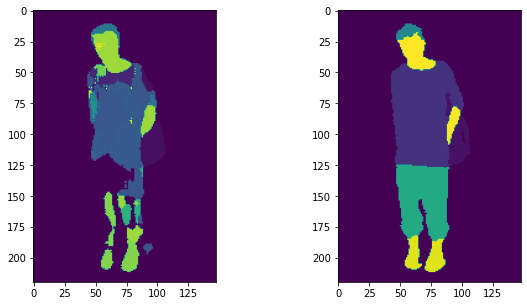

iou: 0.17953031


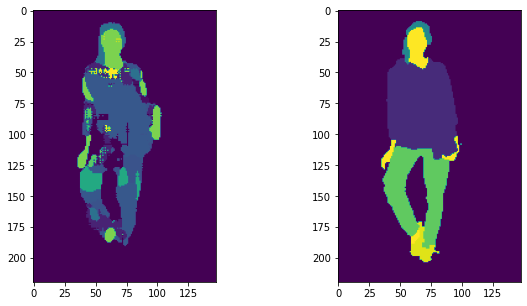

iou: 0.14136721


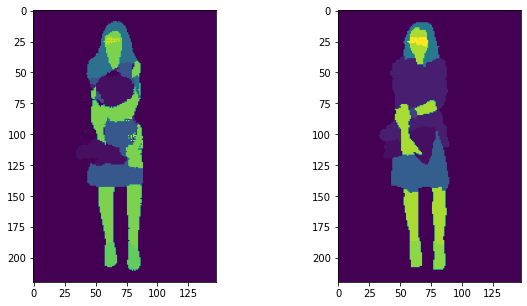

iou: 0.2671362


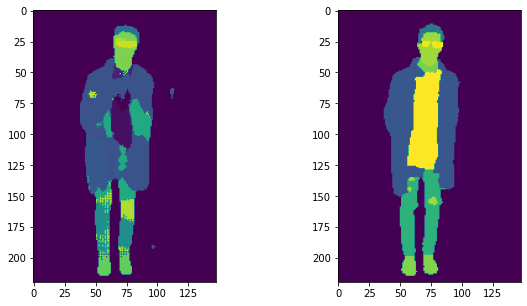

iou: 0.23441225


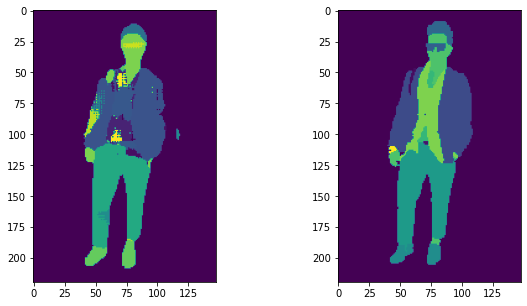

iou: 0.1818691


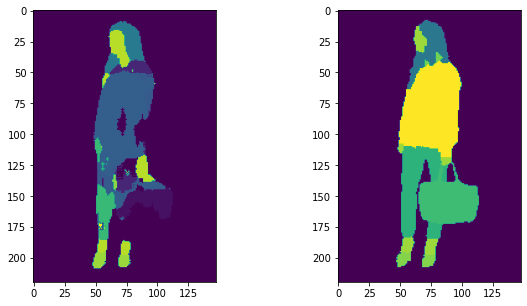

iou: 0.21407548


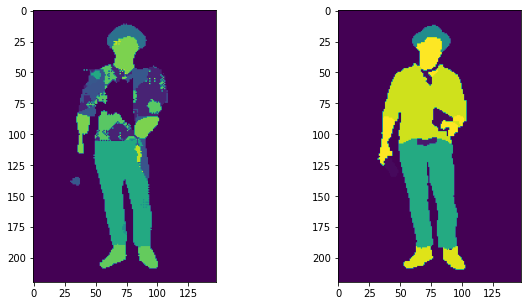

iou: 0.16104424


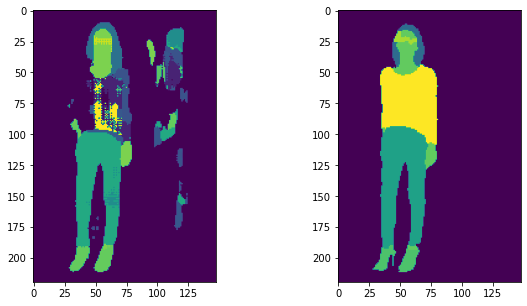

iou: 0.22603826


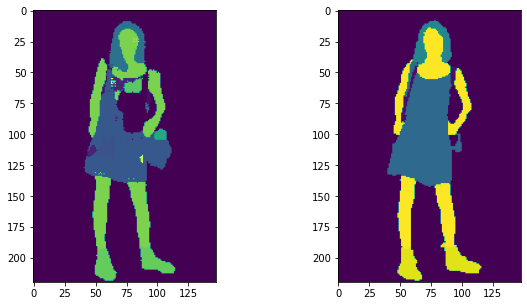

iou: 0.25992414


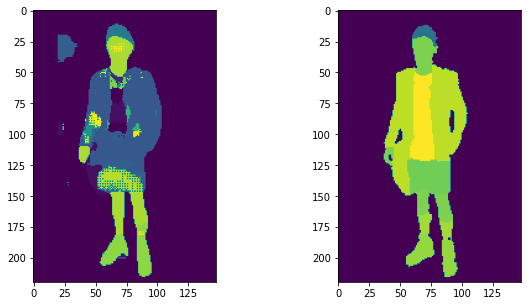

iou: 0.12002996


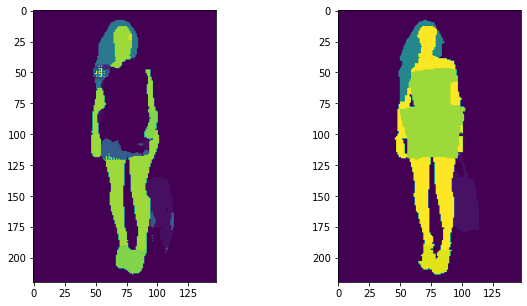

iou: 0.24785025


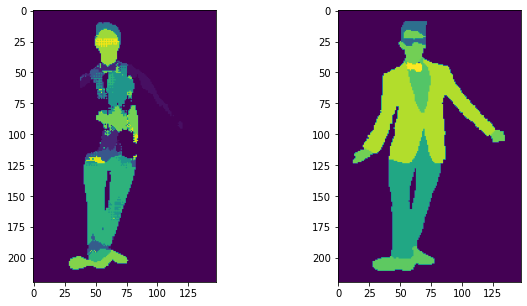

iou: 0.17271651


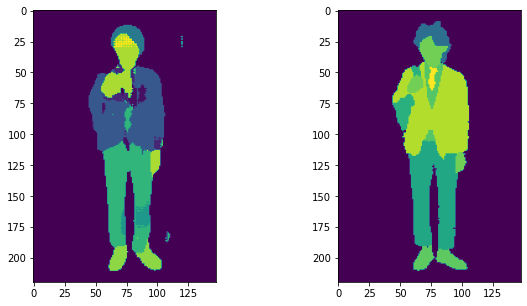

iou: 0.22279525


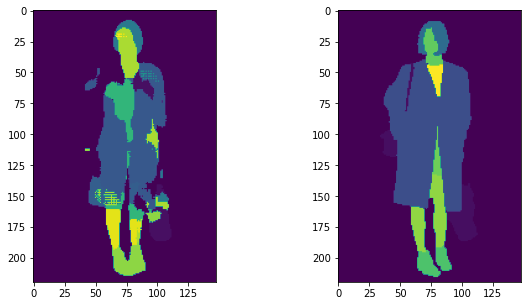

iou: 0.25648576


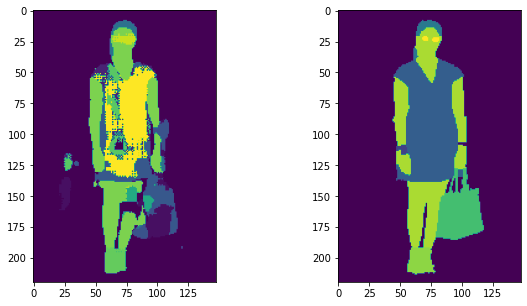

iou: 0.19617766


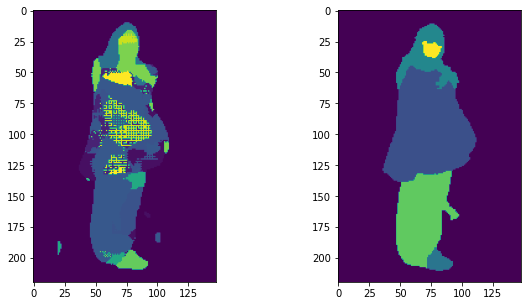

iou: 0.102803834


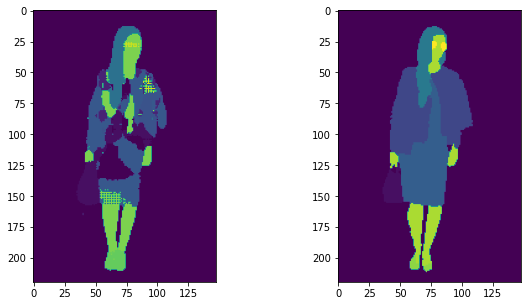

iou: 0.2141807


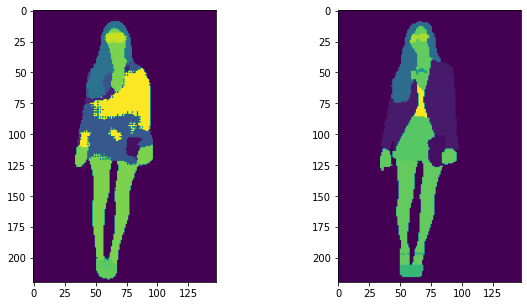

iou: 0.21888444


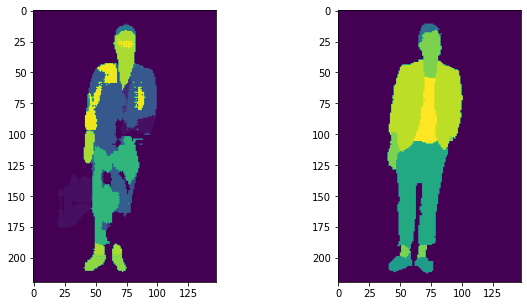

iou: 0.17579639


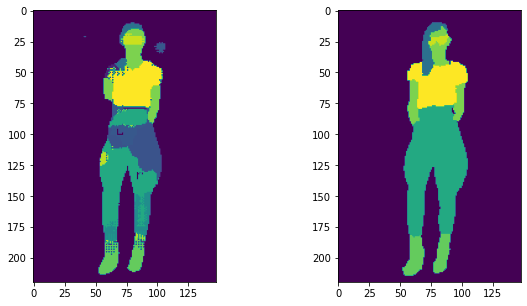

iou: 0.24974976


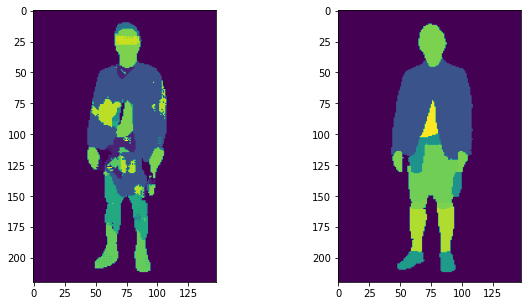

iou: 0.09344189


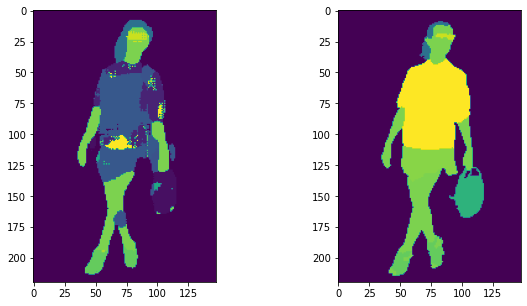

iou: 0.18735859


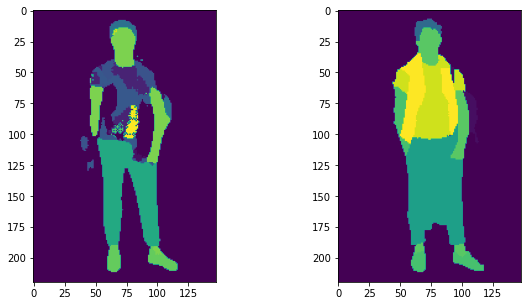

iou: 0.23514137


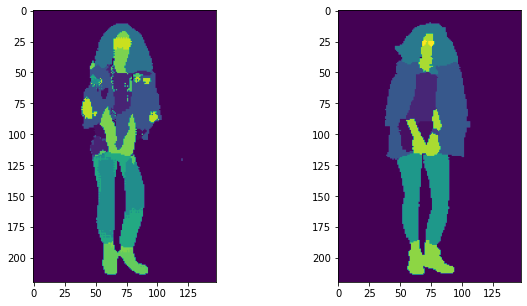

iou: 0.26592186


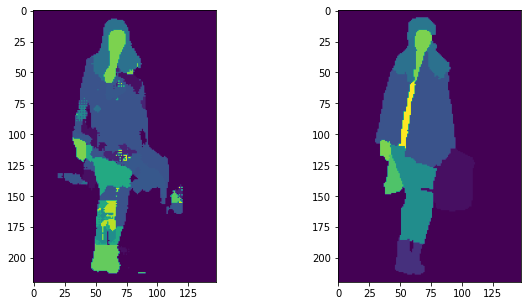

iou: 0.14178811


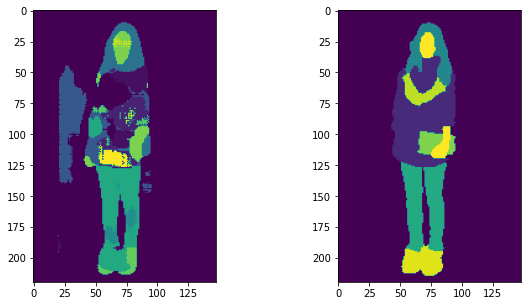

iou: 0.15543666
max_iou: 0.3455663
min_iou: 0.07843813


In [ ]:
show_size = 250

test_set_count = test_label.shape[0]
max_iou_index = 0
max_iou = 0
min_iou_index = 0
min_iou = 100
iou_sum = 0

for i in range(test_set_count):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(test_model_predicted_mask[i,:,:,0])
  plt.subplot(1,2,2)
  plt.imshow(test_label[i,:,:,0])
  plt.show()
  m = tf.keras.metrics.MeanIoU(num_classes=59,)
  m.update_state(test_model_predicted_mask[i], test_label[i])
  iou = m.result().numpy()
  iou_sum += iou 
  if(m.result().numpy() < min_iou):
    min_iou = iou
    min_iou_index = i 
  if(m.result().numpy() > max_iou):
    max_iou = iou
    max_iou_index = i  
  print("iou:",iou)

print("max_iou:",max_iou)
print("min_iou:",min_iou)


# plt.subplot(3,2,3)
# plt.imshow(test_model_predicted_mask[10,:,:,0])
# plt.subplot(3,2,4)
# plt.imshow(test_label[10,:,:,0])

# plt.subplot(3,2,5)
# plt.imshow(test_model_predicted_mask[50,:,:,0])
# plt.subplot(3,2,6)
# plt.imshow(test_label[50,:,:,0])


max_iou_index: 65
max_iou: 0.3455663


Text(0.5, 1.0, 'ground truth')

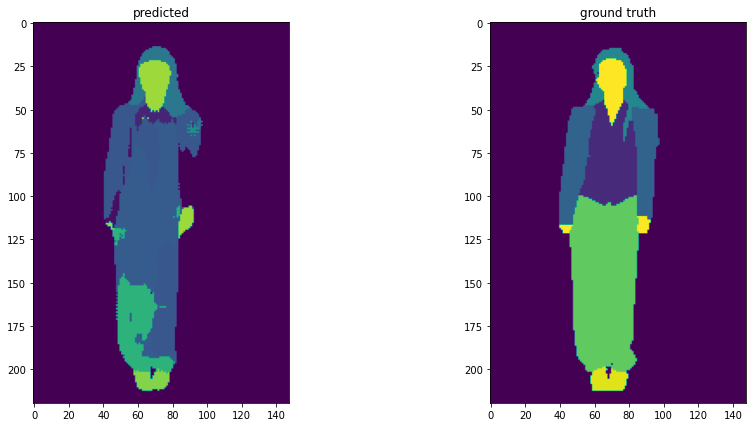

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[max_iou_index,:,:,0])
plt.title('predicted')
plt.subplot(1,2,2)
plt.imshow(test_label[max_iou_index,:,:,0])
print("max_iou_index:",max_iou_index)
print("max_iou:",max_iou)
plt.title('ground truth')

min_iou_index: 53
min_iou: 0.07843813


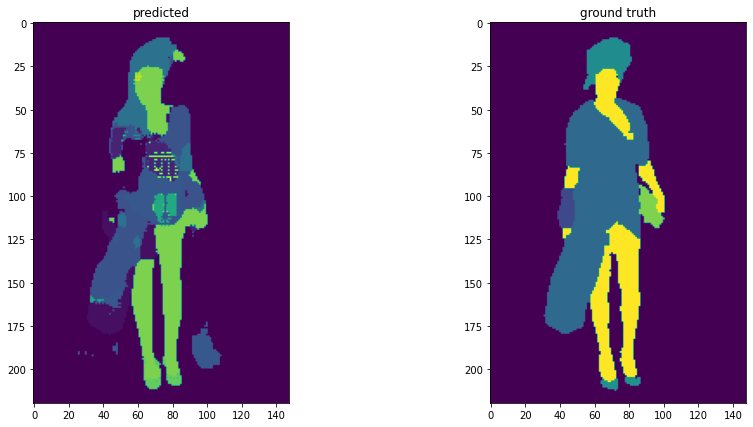

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[min_iou_index,:,:,0])
plt.title('predicted')
plt.subplot(1,2,2)
plt.imshow(test_label[min_iou_index,:,:,0])
plt.title('ground truth')
print("min_iou_index:",min_iou_index)
print("min_iou:",min_iou)


In [ ]:
print("iou sum:",iou_sum)
print("test_set_count:",test_set_count)
print("average iou:",iou_sum*1.0/test_set_count)

iou sum: 46.778146758675575
test_set_count: 250
average iou: 0.1871125870347023


Text(0.5, 1.0, 'ground truth')

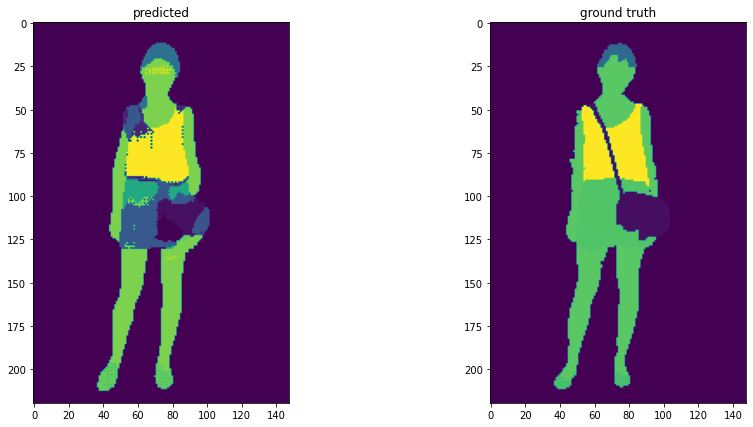

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[7,:,:,0])
plt.title('predicted')
plt.subplot(1,2,2)
plt.imshow(test_label[7,:,:,0])
plt.title('ground truth')